In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict
from linearmodels.iv.results import compare
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from doubleml import DoubleMLData, DoubleMLClusterData, DoubleMLPLIV
from doubleml.utils import DMLDummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-clsrvcy8 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def print_metrics(metrics, dataset_type):
    print(f"{dataset_type} Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")

def evaluate_predictions(predictions, true_values, target_name="TargetVariable", time_values=None):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        time_values (pd.Series): Time values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Extract years for coloring
    if time_values is not None:
        unique_years = time_values.unique()
        norm = mcolors.Normalize(vmin=min(unique_years), vmax=max(unique_years))
        cmap = cm.viridis
        colors = cmap(norm(time_values))
    else:
        colors = 'blue'  # Default color if no time_values provided

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.scatter(true_values, predictions, c=colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Residuals plot
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import random
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Generate distinct colors for each unique country
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)

        # Generate a list of random, unique colors
        random.seed(42)  # Ensures reproducibility
        colors = [
            (random.random(), random.random(), random.random())
            for _ in range(num_countries)
        ]
        cmap = ListedColormap(colors)

        # Map each country to a unique color
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'  # Default color if no country_values provided
        color_mapping = None

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Residuals plot
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
data_1 = pd.read_csv('/workspace/new_data/filtered_data_with_holidays_updated.csv', index_col=0)
data_1

Unnamed: 0                 Time PriceArea  ConsumptionValue  \
Unnamed: 0.1                                                                
0.0                  0.0  2015-01-01 01:00:00        CH            7654.0   
1.0                 17.0  2015-01-01 01:00:00        SK            2728.0   
2.0                 16.0  2015-01-01 01:00:00        SI            1045.0   
3.0                 15.0  2015-01-01 01:00:00        PT            5124.0   
4.0                 10.0  2015-01-01 01:00:00      DK_2            1305.0   
...                  ...                  ...       ...               ...   
NaN                  NaN  2025-01-01 00:00:00      SE_2            1791.0   
NaN                  NaN  2025-01-01 00:00:00      SE_3            9658.0   
NaN                  NaN  2025-01-01 00:00:00      SE_4            2146.0   
NaN                  NaN  2025-01-01 00:00:00        SI            1159.0   
NaN                  NaN  2025-01-01 00:00:00        SK            2524.0   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature    Year  \
Unnamed: 0.1                                                                   
0.0                      38.08          3.647062          267.706482  2015.0   
1.0                      22.06          3.991796          265.239655  2015.0   
2.0                      22.20          4.172168          265.189819  2015.0   
3.0                      47.33          6.417383          279.455658  2015.0   
4.0                      16.04         10.561893          276.635590  2015.0   
...                        ...               ...                 ...     ...   
NaN                       3.69          3.096981          262.690735  2025.0   
NaN                       2.47          7.332158          272.276581  2025.0   
NaN                       2.04         14.230573          276.445221  2025.0   
NaN                     129.07          3.418118          274.394440  2025.0   
NaN                     138.56          6.014961          268.740997  2025.0   

              Month  Day  ...         YearMonthDay  Price_Area  Price_gas  \
Unnamed: 0.1              ...                                               
0.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
1.0             1.0  1.0  ...           2015-01-01          cz     20.650   
2.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
3.0             1.0  1.0  ...           2015-01-01          cz     20.650   
4.0             1.0  1.0  ...           2015-01-01         etf     20.650   
...             ...  ...  ...                  ...         ...        ...   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00        cegh     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00          cz     48.889   

              Price_coal  Price_EUA IsHoliday  B16  B18     B19 Price_gas_ttf  
Unnamed: 0.1                                                                   
0.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
1.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
2.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
3.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
4.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
...                  ...        ...       ...  ...  ...     ...           ...  
NaN                114.5      73.00       NaN  0.0  NaN   243.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN  2131.0           NaN  
NaN                114.5      73.00       NaN  1.0  NaN  1849.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN     0.0           NaN  
NaN      

In [ ]:
# Convert 'Time' to datetime just to be sure
data_1['Time'] = pd.to_datetime(data_1['Time'])

# Full list of rows to remove
rows_to_remove = [
    ("2022-02-10 20:00:00", "SE_2"),
    ("2022-02-10 21:00:00", "SE_2"),
    ("2022-02-10 22:00:00", "SE_2"),
    ("2020-02-27 09:00:00", "DK_2"),
    ("2024-10-22 14:00:00", "DK_2"),
    ("2017-05-08 07:00:00", "DK_1"),
    ("2018-02-06 12:00:00", "DK_2"),
    ("2021-12-17 18:00:00", "IT_CALA"),
    ("2021-12-20 08:00:00", "IT_CALA"),
    ("2021-12-20 15:00:00", "IT_CALA"),
    ("2022-01-25 08:00:00", "IT_CALA"),
    ("2021-12-20 19:00:00", "IT_CALA"),
    ("2017-05-08 06:00:00", "DK_1"),
    ("2021-11-29 16:00:00", "IT_CALA"),
    ("2021-12-17 16:00:00", "IT_CALA"),
]

# Filter out the rows
for time_str, country in rows_to_remove:
    timestamp = pd.to_datetime(time_str)
    data_1 = data_1[~((data_1['Time'] == timestamp) & (data_1['PriceArea'] == country))]

# CIV(Wt,Wt−1 | (Pt,Dt−1) → Dt | ∅)

In [ ]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized'
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])['ConsumptionValue']
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['Lag1_Price'] = data.groupby('Country')['DayAheadPriceEUR'].shift(1)
    data['RollingStd24_LaggedPrice'] = data.groupby(['Country', 'Year'])['Lag1_Price'].transform(
        lambda x: x.rolling(window=24, min_periods=12).std()
    )
    price_threshold = data['Lag1_Price'].quantile(0.95)
    data['LaggedPriceSpike'] = (data['Lag1_Price'] > price_threshold).astype(int)


    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Optionally add lagged features
    data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
    data['Lag1_Total_Wind_Generation'] = data.groupby('Country')['Total_Wind_Generation'].shift(1)



    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    endogenous_variable = ['DayAheadPriceEUR', 'Lag1_Consumption']
    instrument_variables = ['Total_Wind_Generation', 'Lag1_Total_Wind_Generation']

    key_variables = [dependent_variable] + endogenous_variable + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [ ]:
processed_end_dem, covariates_end_dem = prepare_data_with_dummies_and_interactions(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)
processed_end_dem = processed_end_dem[processed_end_dem['Time'].dt.year != 2025]
processed_end_dem

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
21.0                28.0 2015-01-01 02:00:00           5879.00   
19.0                20.0 2015-01-01 02:00:00          21286.00   
18.0                23.0 2015-01-01 02:00:00           1745.00   
17.0                22.0 2015-01-01 02:00:00           1236.00   
20.0                26.0 2015-01-01 02:00:00           7397.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00            547.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
21.0                     20.27          5.878027          271.040405  2015   
19.0                     42.27          6.516034          278.325043  2015   
18.0                     14.60         11.060371          278.674744  2015   
17.0                     14.60         10.920368          277.208038  2015   
20.0                     35.47          3.526751          268.095337  2015   
...                        ...               ...                 ...   ...   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                     138.70          1.776654          284.461456  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  block_4.0:tempbin2  \
Unnamed: 0.1                                    ...                       
21.0           1.0   2.0             28.202729  ...                 0.0   
19.0           1.0   2.0             41.315077  ...                 0.0   
18.0           1.0   2.0             41.944539  ...                 0.0   
17.0           1.0   2.0             39.304469  ...                 0.0   
20.0           1.0   2.0             22.901606  ...                 0.0   
...            ...   ...                   ...  ...                 ...   
NaN           31.0  23.0             50.992439  ...                 0.0   
NaN           31.0  23.0             39.085511  ...                 0.0   
NaN           31.0  23.0             25.749757  ...                 0.0   
NaN           31.0  23.0             52.360621  ...                 0.0   
NaN           31.0  23.0             39.424275  ...                 0.0   

              block_4.0:Solar_MWh  block_5.0:tempbin block_5.0:tempbin2  \
Unnamed: 0.1                                                              
21.0                          0.0                0.0                0.0   
19.0                          0.0                0.0                0.0   
18.0                          0.0                0.0                0.0   
17.0                          0.0                0.0                0.0   
20.0                          0.0                0.0                0.0   
...                           ...                ...                ...   
NaN                           0.0                0.0                0.0   
NaN                           0.0                0.0                0.0   
NaN                           0.0                0.0                0.0   
NaN                           0.0                0.0                0.0   
NaN                           0.0                0.0                0.0   

              block_5.0:Solar_MWh  block_6.0:tempbin block_6.0:tempbin2  \
Unnamed: 0.1                                                              
21.0                          0.0     

In [ ]:
covariates_end_dem

['block_4.0:Solar_MWh',
 'PriceArea_AT',
 'HourOfWeek_92',
 'HourOfWeek_79',
 'PriceArea_UA_IPS',
 'HourOfWeek_153',
 'HourOfWeek_126',
 'HourOfWeek_50',
 'block_5.0:Solar_MWh',
 'HourOfWeek_136',
 'PriceArea_DK_1',
 'HourOfWeek_42',
 'HourOfWeek_23',
 'HourOfWeek_114',
 'HourOfWeek_163',
 'HourOfWeek_62',
 'HourOfWeek_27',
 'HourOfWeek_112',
 'HourOfWeek_127',
 'HourOfWeek_138',
 'HourOfWeek_106',
 'HourOfWeek_108',
 'HourOfWeek_165',
 'HourOfWeek_157',
 'PriceArea_SE_3',
 'HourOfWeek_155',
 'HourOfWeek_59',
 'HourOfWeek_128',
 'PriceArea_HU',
 'HourOfWeek_140',
 'HourOfWeek_1',
 'Price_gas',
 'HourOfWeek_70',
 'HourOfWeek_68',
 'HourOfWeek_162',
 'HourOfWeek_64',
 'HourOfWeek_98',
 'HourOfWeek_54',
 'HourOfWeek_120',
 'PriceArea_EE',
 'HourOfWeek_90',
 'PriceArea_PT',
 'HourOfWeek_152',
 'HourOfWeek_154',
 'HourOfWeek_109',
 'HourOfWeek_125',
 'HourOfWeek_107',
 'HourOfWeek_15',
 'PriceArea_IT_CSUD',
 'HourOfWeek_142',
 'HourOfWeek_145',
 'Month_4',
 'PriceArea_SI',
 'PriceArea_NL',


In [ ]:
def dml_rolling_nuins(filtered_data, base_covariates, manual_params_l=None, manual_params_r=None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable='consumption_normalized'):


    data = filtered_data.copy()
    data = data.sort_values(by='Time')
    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    covariates = base_covariates.copy()
    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]


    def tune_xgb_model(X, y, param_dist):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist",
                                 eval_metric="rmse"
                                )
        grid_search = GridSearchCV(model, param_dist, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_

    pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_Total_Wind_Generation': [],
            'ml_m_Lag1_Total_Wind_Generation': []
        },
        'Lag1_Consumption': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_Total_Wind_Generation': [],
            'ml_m_Lag1_Total_Wind_Generation': []
        }
    }

    test_predictions = []
    test_actuals = []
    train_predictions = []
    train_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    fold_feature_importance_df = []
    fold_coefficients = []
    time_indices = []

    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue

        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")



        X_train = train_data[covariates]
        X_test = test_data[covariates]
        y_train = train_data[dependent_variable]
        y_test = test_data[dependent_variable]

        d_train_r1 = train_data['DayAheadPriceEUR']
        d_train_r2 = train_data['Lag1_Consumption']
        z_train_m1 = train_data['Total_Wind_Generation']
        z_train_m2 = train_data['Lag1_Total_Wind_Generation']

        learner_l = xgb.XGBRegressor(**(manual_params_l or tune_xgb_model(X_train, y_train, param_dist_xgb)))
        learner_r1 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r1, param_dist_xgb_r)))
        learner_r2 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r2, param_dist_xgb_r)))
        learner_m1 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m1, param_dist_xgb_m)))
        learner_m2 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m2, param_dist_xgb_m)))

        learner_l.fit(X_train, y_train)
        learner_r1.fit(X_train, d_train_r1)
        learner_r2.fit(X_train, d_train_r2)
        learner_m1.fit(X_train, z_train_m1)
        learner_m2.fit(X_train, z_train_m2)

        pred_l = learner_l.predict(X_test)
        pred_r1 = learner_r1.predict(X_test)
        pred_r2 = learner_r2.predict(X_test)
        pred_m1 = learner_m1.predict(X_test)
        pred_m2 = learner_m2.predict(X_test)

        test_predictions.extend(pred_l)
        test_actuals.extend(y_test)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train)
        time_indices.extend(test_data.index.tolist())

        pred_dict['DayAheadPriceEUR']['ml_l'].extend(pred_l)
        pred_dict['DayAheadPriceEUR']['ml_r'].extend(pred_r1)
        pred_dict['DayAheadPriceEUR']['ml_m_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['DayAheadPriceEUR']['ml_m_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['Lag1_Consumption']['ml_l'].extend(pred_l)
        pred_dict['Lag1_Consumption']['ml_r'].extend(pred_r2)
        pred_dict['Lag1_Consumption']['ml_m_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['Lag1_Consumption']['ml_m_Lag1_Total_Wind_Generation'].extend(pred_m2)


        plt.figure(figsize=(12, 4))
        plt.plot(y_test.iloc[:500].values, label='Actual')
        plt.plot(pred_l[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()

        fold_metrics.append({
            'Test Year': test_year,
            'MAE': mean_absolute_error(y_test, pred_l),
            'RMSE': mean_squared_error(y_test, pred_l, squared=False),
            'R2': r2_score(y_test, pred_l)
        })

        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))

        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols=['DayAheadPriceEUR', 'Lag1_Consumption'],
            z_cols=['Total_Wind_Generation', 'Lag1_Total_Wind_Generation'],
            x_cols=covariates,
            cluster_cols=['Country']
        )
        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            key: {
                'ml_l': np.array(pred_dict[key]['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict[key]['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Total_Wind_Generation': np.array(pred_dict[key]['ml_m_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag1_Total_Wind_Generation': np.array(pred_dict[key]['ml_m_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1)
            } for key in pred_dict
        })

        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })

    print("Overall Train Metrics:")
    print("MAE:", mean_absolute_error(train_actuals, train_predictions))
    print("RMSE:", mean_squared_error(train_actuals, train_predictions, squared=False))
    print("R²:", r2_score(train_actuals, train_predictions))

    print("Overall Test Metrics:")
    print("MAE:", mean_absolute_error(test_actuals, test_predictions))
    print("RMSE:", mean_squared_error(test_actuals, test_predictions, squared=False))
    print("R²:", r2_score(test_actuals, test_predictions))

    feature_importances_per_window.append(learner_l.feature_importances_)
    mean_importances = feature_importances_array.mean(axis=0)
    std_importances = feature_importances_array.std(axis=0)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': mean_importances,
        'Std Importance': std_importances}).sort_values(by='Mean Importance', ascending=False)

    # Remove NaNs and ensure integer type
    time_indices = [i for i in time_indices if pd.notna(i)]
    filtered_data = data.loc[time_indices].copy().reset_index(drop=True)
    for key in pred_dict:
        for learner_key in pred_dict[key]:
            arr = np.array(pred_dict[key][learner_key])
            pred_dict[key][learner_key] = arr[-len(filtered_data):].reshape(-1, 1)

    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols=['DayAheadPriceEUR', 'Lag1_Consumption'],
        z_cols=['Total_Wind_Generation', 'Lag1_Total_Wind_Generation'],
        x_cols=covariates,
        cluster_cols=['Country']
    )
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
    dml_pliv_obj.fit(external_predictions=pred_dict)

    predicted_ml_l = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Prrediction"] = predicted_ml_l[-len(filtered_data):]
    filtered_data["Residuals"] = filtered_data["Prrediction"] - filtered_data[dependent_variable]

    return dml_pliv_obj, filtered_data, importance_df, pd.DataFrame(fold_metrics), pd.concat(fold_feature_importance_df, ignore_index=True), fold_coefficients, predicted_ml_l


In [ ]:
manual_params_l = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.02,
    'max_depth': 5,
    'n_estimators': 400,
    'subsample': 0.8
}

manual_params_r = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'subsample': 0.7
}

manual_params_m = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.01,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 0.9
}


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401794 | Test samples: 209955


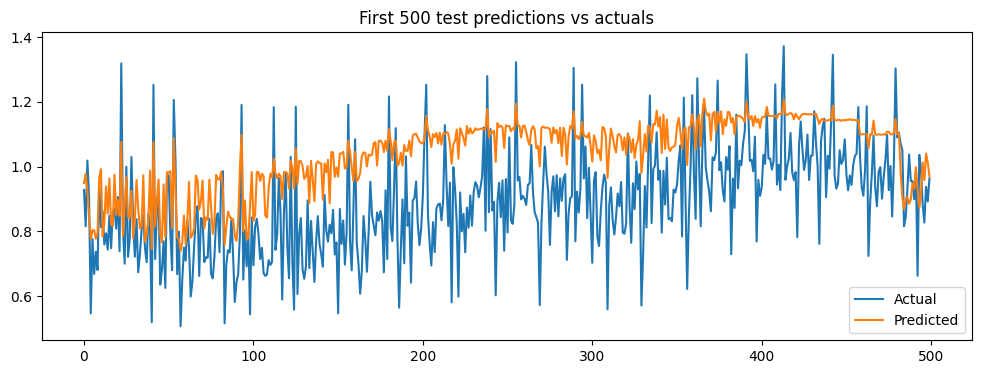


Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412296 | Test samples: 203208


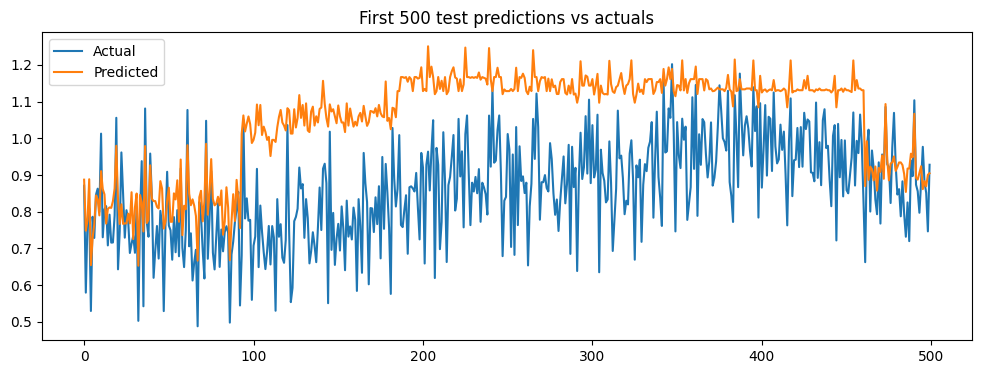


Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221270


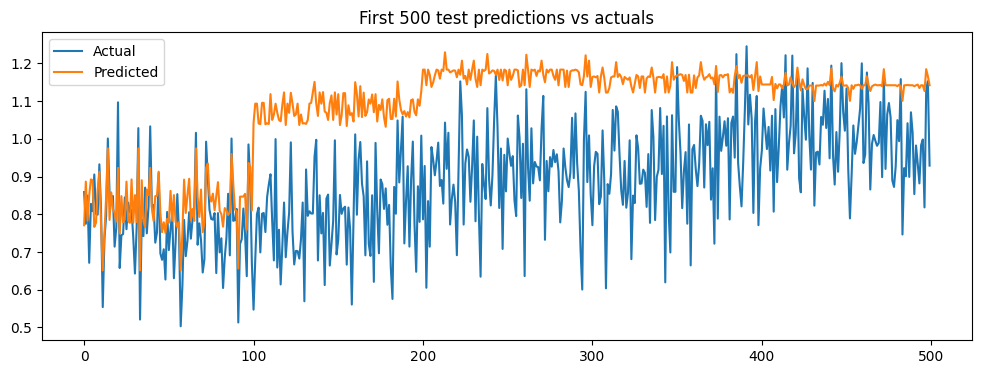


Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424478 | Test samples: 234724


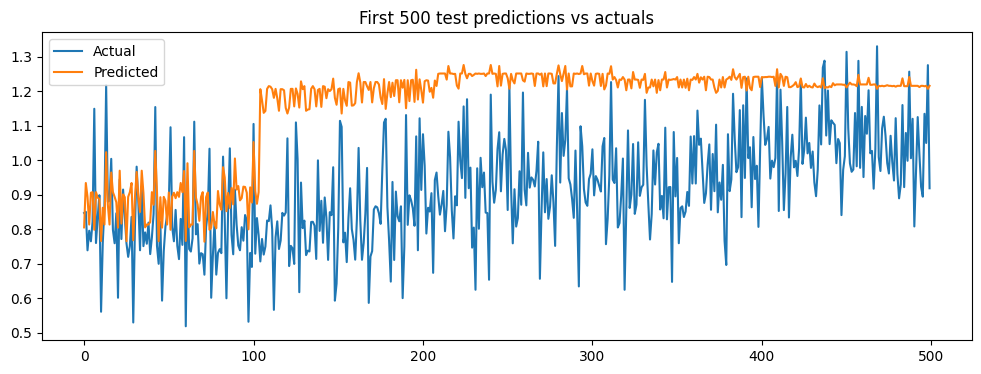


Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455994 | Test samples: 252358


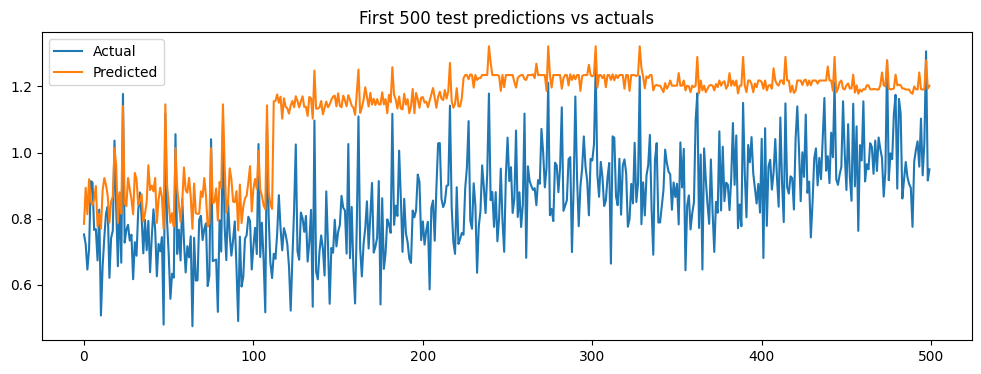


Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487082 | Test samples: 282858


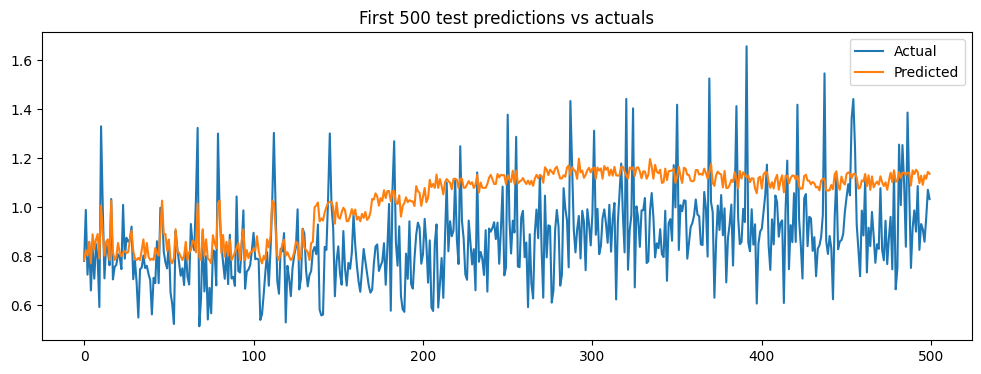


Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535216 | Test samples: 289869


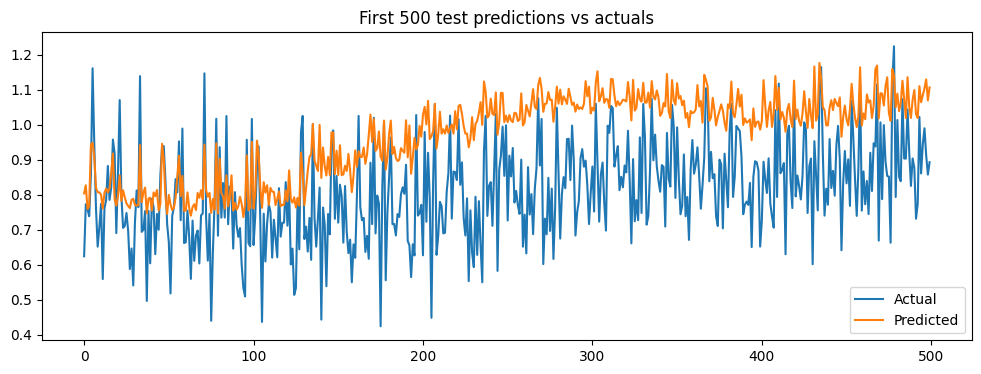


Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572727 | Test samples: 304063


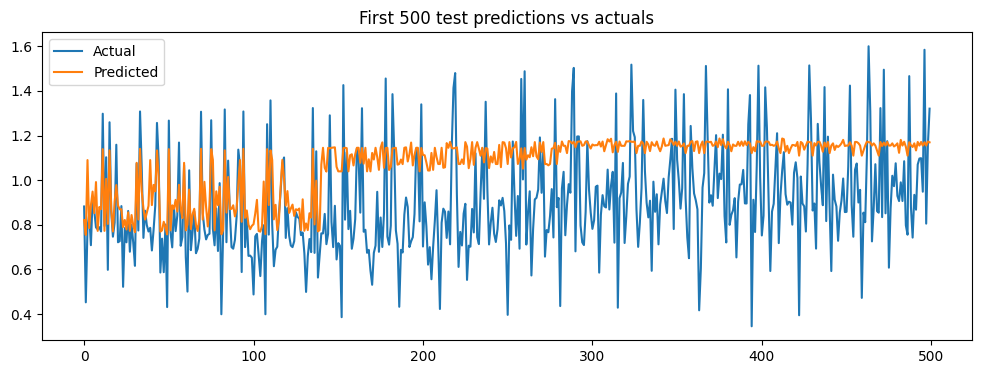

Overall Train Metrics:
MAE: 0.08759563365250292
RMSE: 0.11229667144051729
R²: 0.6563727912703472
Overall Test Metrics:
MAE: 0.1008900687454762
RMSE: 0.13032901263098975
R²: 0.553369438353835


<ipython-input-49-83e1aff812d8>:178: RuntimeWarning: Mean of empty slice.
  mean_importances = feature_importances_array.mean(axis=0)
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
dml_pliv_deamnd_lag_tretm, filtered_data_deamnd_lag_tretm, importance_df_deamnd_lag_tretm, fold_metrics_df_deamnd_lag_tretm, importance_all_folds_df_deamnd_lag_tretm, fold_coefficients_deamnd_lag_tretm, predicted_ml_l = dml_rolling_nuins(processed_end_dem,
                                                                                                                             covariates_end_dem,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
print(dml_pliv_deamnd_lag_tretm)

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR', 'Lag1_Consumption']
Cluster variable(s): ['Country']
Covariates: ['block_4.0:Solar_MWh', 'PriceArea_AT', 'HourOfWeek_92', 'HourOfWeek_79', 'PriceArea_UA_IPS', 'HourOfWeek_153', 'HourOfWeek_126', 'HourOfWeek_50', 'block_5.0:Solar_MWh', 'HourOfWeek_136', 'PriceArea_DK_1', 'HourOfWeek_42', 'HourOfWeek_23', 'HourOfWeek_114', 'HourOfWeek_163', 'HourOfWeek_62', 'HourOfWeek_27', 'HourOfWeek_112', 'HourOfWeek_127', 'HourOfWeek_138', 'HourOfWeek_106', 'HourOfWeek_108', 'HourOfWeek_165', 'HourOfWeek_157', 'PriceArea_SE_3', 'HourOfWeek_155', 'HourOfWeek_59', 'HourOfWeek_128', 'PriceArea_HU', 'HourOfWeek_140', 'HourOfWeek_1', 'Price_gas', 'HourOfWeek_70', 'HourOfWeek_68', 'HourOfWeek_162', 'HourOfWeek_64', 'HourOfWeek_98', 'HourOfWeek_54', 'HourOfWeek_120', 'PriceArea_EE', 'HourOfWeek_90', 'PriceArea_

In [ ]:
covariates_regression = [var for var in covariates_end_dem if var not in ['HourOfWeek_0', 'Month_1']]

In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR', 'Lag1_Consumption']
instrument_vars = ['Total_Wind_Generation', 'Lag1_Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_deamnd_lag_tretm[outcome_var]
D = filtered_data_deamnd_lag_tretm[treatment_var]
Z = filtered_data_deamnd_lag_tretm[instrument_vars]
W = filtered_data_deamnd_lag_tretm[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_deamnd_lag_tretm[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                     -0.3456
Estimator:                        IV-2SLS   Adj. R-squared:                -0.3457
No. Observations:                 1844284   F-statistic:                -7.536e+11
Date:                    Wed, Apr 09 2025   P-value (F-stat)                1.0000
Time:                            08:06:49   Distribution:                chi2(239)
Cov. Estimator:                 clustered                                         
                                                                                  
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
block_4.0:Solar_MWh -1.246e-06  3.471e-06    -0.3591     0.7196  -8.049e

In [ ]:
filtered_data_deamnd_lag_tretm.to_csv("filtered_data_deamnd_lag_tretm.csv", index=False)
importance_df_deamnd_lag_tretm.to_csv("importance_df_deamnd_lag_tretm.csv", index=False)
fold_coefficients_deamnd_lag_tretm = pd.DataFrame(fold_coefficients_deamnd_lag_tretm)
fold_coefficients_deamnd_lag_tretm.to_csv("fold_coefficients_deamnd_lag_tretm.csv", index=False)

In [ ]:
importance_df_deamnd_lag_tretm = (
    importance_all_folds_df_deamnd_lag_tretm
    .groupby("Feature")
    .agg(
        Mean_Importance=("Importance", "mean"),
        Std_Importance=("Importance", "std")
    )
    .reset_index()
    .sort_values(by="Mean_Importance", ascending=False)
)
importance_df_deamnd_lag_tretm

Feature  Mean_Importance  Std_Importance
222   block_1.0:tempbin         0.074718        0.018470
238  block_6.0:tempbin2         0.067467        0.007441
223  block_1.0:tempbin2         0.061964        0.006488
237   block_6.0:tempbin         0.058769        0.007286
172             Month_2         0.029881        0.010677
..                  ...              ...             ...
106       HourOfWeek_43         0.000000        0.000000
206      PriceArea_NO_1         0.000000        0.000000
103       HourOfWeek_40         0.000000        0.000000
10       HourOfWeek_107         0.000000        0.000000
140       HourOfWeek_74         0.000000        0.000000

[239 rows x 3 columns]

In [ ]:
important_features = importance_df_deamnd_lag_tretm[importance_df_deamnd_lag_tretm['Mean_Importance'] > 0.0004]['Feature'].tolist()
important_features

['block_1.0:tempbin',
 'block_6.0:tempbin2',
 'block_1.0:tempbin2',
 'block_6.0:tempbin',
 'Month_2',
 'Month_1',
 'HourOfWeek_149',
 'HourOfWeek_150',
 'Month_5',
 'HourOfWeek_125',
 'HourOfWeek_151',
 'Month_12',
 'HourOfWeek_158',
 'HourOfWeek_157',
 'HourOfWeek_156',
 'HourOfWeek_126',
 'HourOfWeek_153',
 'HourOfWeek_155',
 'HourOfWeek_159',
 'HourOfWeek_154',
 'HourOfWeek_164',
 'HourOfWeek_152',
 'HourOfWeek_140',
 'HourOfWeek_56',
 'HourOfWeek_132',
 'HourOfWeek_45',
 'HourOfWeek_134',
 'HourOfWeek_80',
 'HourOfWeek_32',
 'HourOfWeek_133',
 'HourOfWeek_69',
 'Month_3',
 'HourOfWeek_93',
 'HourOfWeek_160',
 'HourOfWeek_131',
 'HourOfWeek_21',
 'block_5.0:tempbin',
 'HourOfWeek_135',
 'HourOfWeek_104',
 'Month_4',
 'HourOfWeek_55',
 'HourOfWeek_163',
 'HourOfWeek_130',
 'HourOfWeek_79',
 'HourOfWeek_31',
 'HourOfWeek_65',
 'block_3.0:tempbin',
 'HourOfWeek_129',
 'HourOfWeek_127',
 'HourOfWeek_66',
 'HourOfWeek_144',
 'HourOfWeek_0',
 'HourOfWeek_167',
 'HourOfWeek_41',
 'Price_ga


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401794 | Test samples: 209955


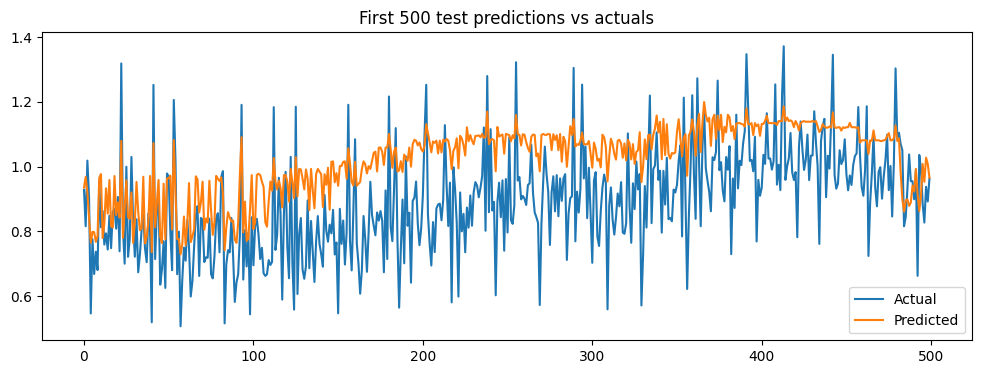


Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412296 | Test samples: 203208


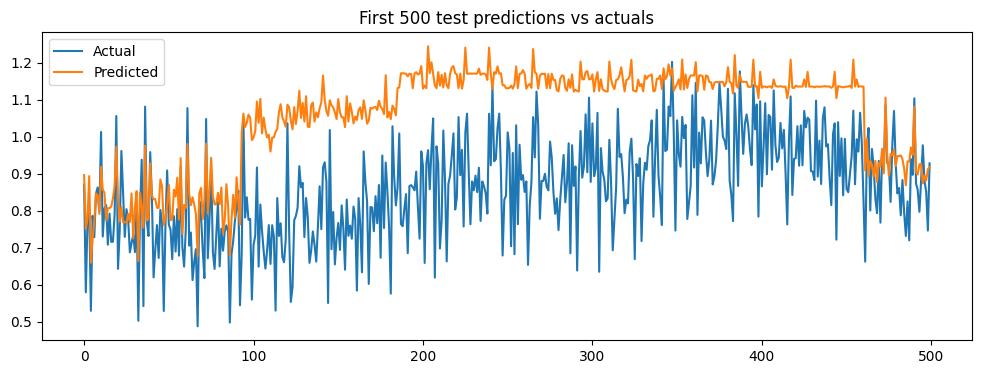


Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221270


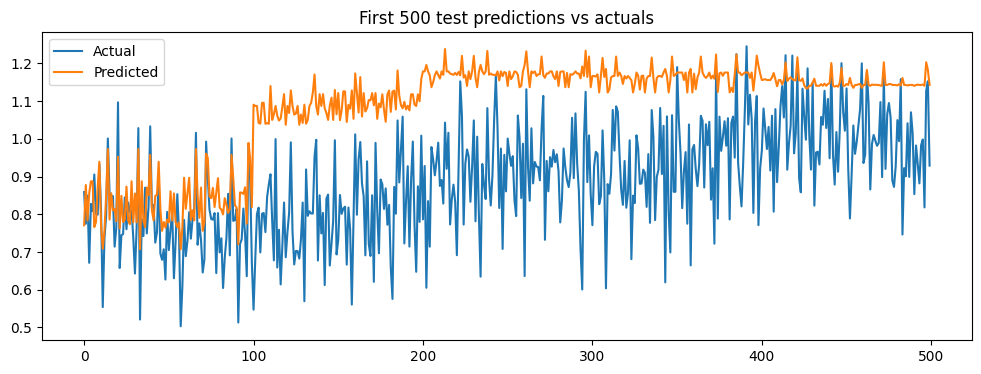


Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424478 | Test samples: 234724


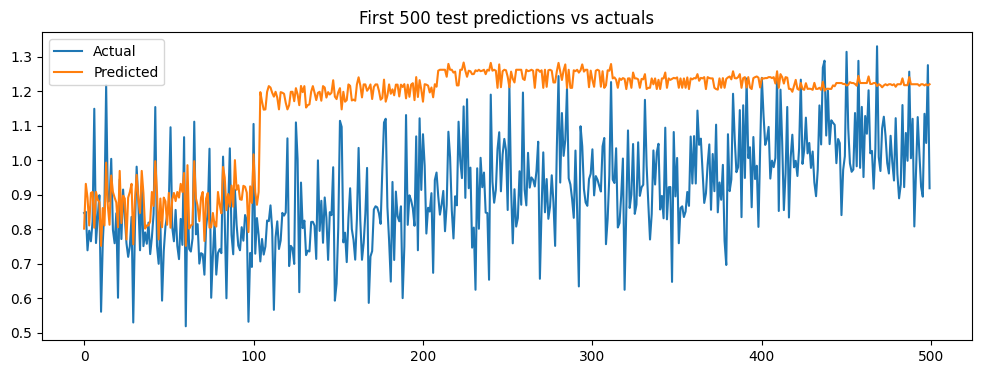


Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455994 | Test samples: 252358


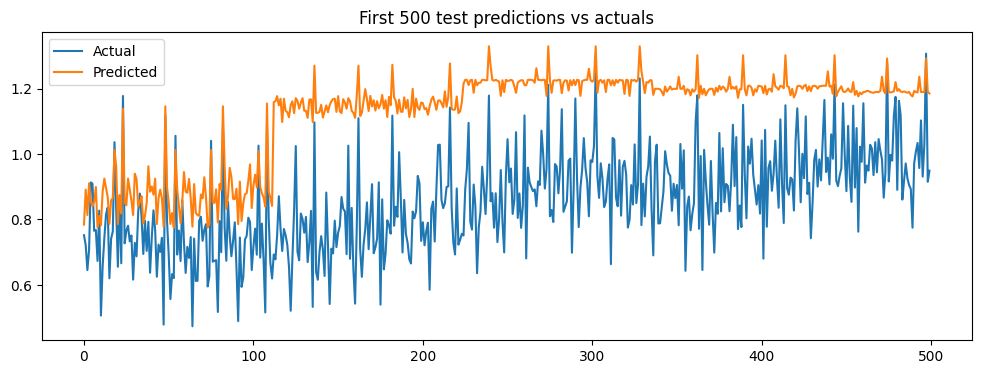


Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487082 | Test samples: 282858


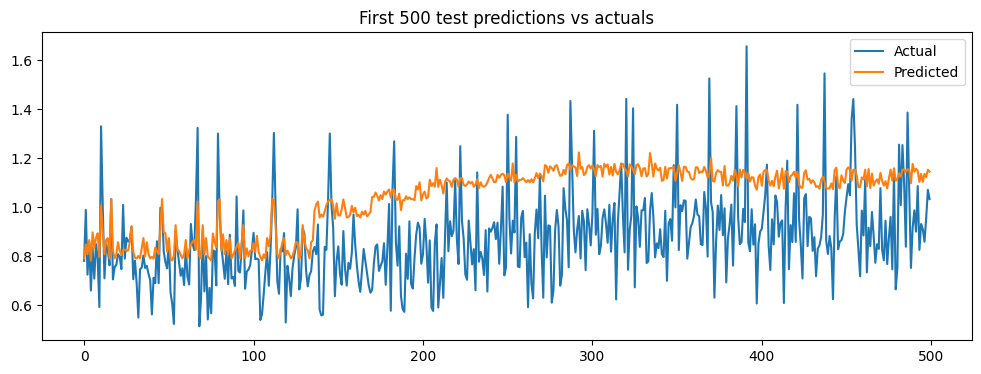


Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535216 | Test samples: 289869


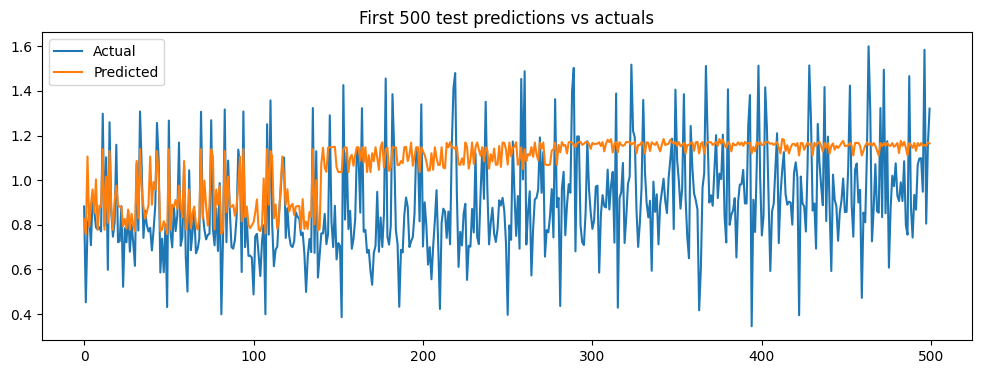

Overall Train Metrics:
MAE: 0.08766040295061404
RMSE: 0.11240476612983803
R²: 0.6557109345458656
Overall Test Metrics:
MAE: 0.10078401058741279
RMSE: 0.130051743180496
R²: 0.5552677920497407


<ipython-input-49-83e1aff812d8>:178: RuntimeWarning: Mean of empty slice.
  mean_importances = feature_importances_array.mean(axis=0)
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
dml_pliv_deamnd_lag_tretm, filtered_data_deamnd_lag_tretm, importance_df_deamnd_lag_tretm, fold_metrics_df_deamnd_lag_tretm, importance_all_folds_df_deamnd_lag_tretm, fold_coefficients_deamnd_lag_tretm, predicted_ml_l = dml_rolling_nuins(processed_end_dem,
                                                                                                                             important_features,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
print(dml_pliv_deamnd_lag_tretm)

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR', 'Lag1_Consumption']
Cluster variable(s): ['Country']
Covariates: ['block_1.0:tempbin', 'block_6.0:tempbin2', 'block_1.0:tempbin2', 'block_6.0:tempbin', 'Month_2', 'Month_1', 'HourOfWeek_149', 'HourOfWeek_150', 'Month_5', 'HourOfWeek_125', 'HourOfWeek_151', 'Month_12', 'HourOfWeek_158', 'HourOfWeek_157', 'HourOfWeek_156', 'HourOfWeek_126', 'HourOfWeek_153', 'HourOfWeek_155', 'HourOfWeek_159', 'HourOfWeek_154', 'HourOfWeek_164', 'HourOfWeek_152', 'HourOfWeek_140', 'HourOfWeek_56', 'HourOfWeek_132', 'HourOfWeek_45', 'HourOfWeek_134', 'HourOfWeek_80', 'HourOfWeek_32', 'HourOfWeek_133', 'HourOfWeek_69', 'Month_3', 'HourOfWeek_93', 'HourOfWeek_160', 'HourOfWeek_131', 'HourOfWeek_21', 'block_5.0:tempbin', 'HourOfWeek_135', 'HourOfWeek_104', 'Month_4', 'HourOfWeek_55', 'HourOfWeek_163', 'HourOfWee

##  CIV(Wt,Wt−1, Wt-2 | (Pt,Pt−1,Dt−1) → Dt | ∅)

In [ ]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized'
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)



    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Optionally add lagged features
    data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
    data['Lag1_Total_Wind_Generation'] = data.groupby('Country')['Total_Wind_Generation'].shift(1)
    data['Lag2_Total_Wind_Generation'] = data.groupby('Country')['Total_Wind_Generation'].shift(2)
    data['Lag1_DayAheadPriceEUR'] = data.groupby('Country')['DayAheadPriceEUR'].shift(1)



    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    endogenous_variable = ['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR']
    instrument_variables = ['Total_Wind_Generation', 'Lag1_Total_Wind_Generation', 'Lag2_Total_Wind_Generation']

    key_variables = [dependent_variable] + endogenous_variable + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [ ]:
processed_end_dem_price, covariates_end_dem_price = prepare_data_with_dummies_and_interactions(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)
processed_end_dem_price = processed_end_dem_price[processed_end_dem_price['Time'].dt.year != 2025]
processed_end_dem_price

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
34.0                41.0 2015-01-01 03:00:00          20264.00   
33.0                42.0 2015-01-01 03:00:00           4879.00   
31.0                45.0 2015-01-01 03:00:00           5828.00   
30.0                46.0 2015-01-01 03:00:00            747.00   
29.0                47.0 2015-01-01 03:00:00           1190.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00            547.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
34.0                     38.41          6.339060          278.225769  2015   
33.0                     25.40         14.278077          274.781555  2015   
31.0                     19.17          5.852193          271.318787  2015   
30.0                     17.53          7.799719          273.991302  2015   
29.0                     14.95         11.110504          277.601593  2015   
...                        ...               ...                 ...   ...   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                     138.70          1.776654          284.461456  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  block_5.0:tempbin  \
Unnamed: 0.1                                    ...                      
34.0           1.0   3.0             41.136384  ...                0.0   
33.0           1.0   3.0             34.936799  ...                0.0   
31.0           1.0   3.0             28.703816  ...                0.0   
30.0           1.0   3.0             33.514344  ...                0.0   
29.0           1.0   3.0             40.012867  ...                0.0   
...            ...   ...                   ...  ...                ...   
NaN           31.0  23.0             50.992439  ...                0.0   
NaN           31.0  23.0             39.085511  ...                0.0   
NaN           31.0  23.0             25.749757  ...                0.0   
NaN           31.0  23.0             52.360621  ...                0.0   
NaN           31.0  23.0             39.424275  ...                0.0   

              block_5.0:tempbin2  block_5.0:Solar_MWh block_6.0:tempbin  \
Unnamed: 0.1                                                              
34.0                         0.0                  0.0               0.0   
33.0                         0.0                  0.0               0.0   
31.0                         0.0                  0.0               0.0   
30.0                         0.0                  0.0               0.0   
29.0                         0.0                  0.0               0.0   
...                          ...                  ...               ...   
NaN                          0.0                  0.0               4.0   
NaN                          0.0                  0.0               2.0   
NaN                          0.0                  0.0               1.0   
NaN                          0.0                  0.0               4.0   
NaN                          0.0                  0.0               2.0   

              block_6.0:tempbin2  block_6.0:Solar_MWh Lag1_Consumption  \
Unnamed: 0.1                                                             
34.0                    0.000000                  0.0

In [ ]:
def dml_rolling_nuins_price_dm(filtered_data, base_covariates, manual_params_l=None, manual_params_r=None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable='consumption_normalized'):


    data = filtered_data.copy()
    data = data.sort_values(by='Time')
    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    covariates = base_covariates.copy()
    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]


    def tune_xgb_model(X, y, param_dist):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist",
                                 eval_metric="rmse"
                                )
        grid_search = GridSearchCV(model, param_dist, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_

    pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_Total_Wind_Generation': [],
            'ml_m_Lag1_Total_Wind_Generation': [],
            'ml_m_Lag2_Total_Wind_Generation': []
        },
        'Lag1_Consumption': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_Total_Wind_Generation': [],
            'ml_m_Lag1_Total_Wind_Generation': [],
            'ml_m_Lag2_Total_Wind_Generation': []
        },
        'Lag1_DayAheadPriceEUR': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_Total_Wind_Generation': [],
            'ml_m_Lag1_Total_Wind_Generation': [],
            'ml_m_Lag2_Total_Wind_Generation': []
        }
    }

    test_predictions = []
    test_actuals = []
    train_predictions = []
    train_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    fold_feature_importance_df = []
    fold_coefficients = []
    time_indices = []

    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue

        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")



        X_train = train_data[covariates]
        X_test = test_data[covariates]
        y_train = train_data[dependent_variable]
        y_test = test_data[dependent_variable]

        d_train_r1 = train_data['DayAheadPriceEUR']
        d_train_r2 = train_data['Lag1_Consumption']
        d_train_r3 = train_data['Lag1_DayAheadPriceEUR']
        z_train_m1 = train_data['Total_Wind_Generation']
        z_train_m2 = train_data['Lag1_Total_Wind_Generation']
        z_train_m3 = train_data['Lag2_Total_Wind_Generation']

        learner_l = xgb.XGBRegressor(**(manual_params_l or tune_xgb_model(X_train, y_train, param_dist_xgb)))
        learner_r1 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r1, param_dist_xgb_r)))
        learner_r2 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r2, param_dist_xgb_r)))
        learner_r3 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r3, param_dist_xgb_r)))
        learner_m1 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m1, param_dist_xgb_m)))
        learner_m2 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m2, param_dist_xgb_m)))
        learner_m3 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m3, param_dist_xgb_m)))

        learner_l.fit(X_train, y_train)
        learner_r1.fit(X_train, d_train_r1)
        learner_r2.fit(X_train, d_train_r2)
        learner_r3.fit(X_train, d_train_r3)
        learner_m1.fit(X_train, z_train_m1)
        learner_m2.fit(X_train, z_train_m2)
        learner_m3.fit(X_train, z_train_m3)

        pred_l = learner_l.predict(X_test)
        pred_r1 = learner_r1.predict(X_test)
        pred_r2 = learner_r2.predict(X_test)
        pred_r3 = learner_r3.predict(X_test)
        pred_m1 = learner_m1.predict(X_test)
        pred_m2 = learner_m2.predict(X_test)
        pred_m3 = learner_m3.predict(X_test)

        test_predictions.extend(pred_l)
        test_actuals.extend(y_test)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train)
        time_indices.extend(test_data.index.tolist())

        pred_dict['DayAheadPriceEUR']['ml_l'].extend(pred_l)
        pred_dict['DayAheadPriceEUR']['ml_r'].extend(pred_r1)
        pred_dict['DayAheadPriceEUR']['ml_m_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['DayAheadPriceEUR']['ml_m_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['DayAheadPriceEUR']['ml_m_Lag2_Total_Wind_Generation'].extend(pred_m3)
        pred_dict['Lag1_Consumption']['ml_l'].extend(pred_l)
        pred_dict['Lag1_Consumption']['ml_r'].extend(pred_r2)
        pred_dict['Lag1_Consumption']['ml_m_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['Lag1_Consumption']['ml_m_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['Lag1_Consumption']['ml_m_Lag2_Total_Wind_Generation'].extend(pred_m3)
        pred_dict['Lag1_DayAheadPriceEUR']['ml_l'].extend(pred_l)
        pred_dict['Lag1_DayAheadPriceEUR']['ml_r'].extend(pred_r1)
        pred_dict['Lag1_DayAheadPriceEUR']['ml_m_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['Lag1_DayAheadPriceEUR']['ml_m_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['Lag1_DayAheadPriceEUR']['ml_m_Lag2_Total_Wind_Generation'].extend(pred_m3)

        plt.figure(figsize=(12, 4))
        plt.plot(y_test.iloc[:500].values, label='Actual')
        plt.plot(pred_l[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()

        fold_metrics.append({
            'Test Year': test_year,
            'MAE': mean_absolute_error(y_test, pred_l),
            'RMSE': mean_squared_error(y_test, pred_l, squared=False),
            'R2': r2_score(y_test, pred_l)
        })

        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))

        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols=['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR'],
            z_cols=['Total_Wind_Generation', 'Lag1_Total_Wind_Generation', 'Lag2_Total_Wind_Generation'],
            x_cols=covariates,
            cluster_cols=['Country']
        )
        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'DayAheadPriceEUR': {
                'ml_l': np.array(pred_dict['DayAheadPriceEUR']['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict['DayAheadPriceEUR']['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Total_Wind_Generation': np.array(pred_dict['DayAheadPriceEUR']['ml_m_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag1_Total_Wind_Generation': np.array(pred_dict['DayAheadPriceEUR']['ml_m_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag2_Total_Wind_Generation': np.array(pred_dict['DayAheadPriceEUR']['ml_m_Lag2_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
            },
            'Lag1_Consumption': {
                'ml_l': np.array(pred_dict['Lag1_Consumption']['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict['Lag1_Consumption']['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Total_Wind_Generation': np.array(pred_dict['Lag1_Consumption']['ml_m_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag1_Total_Wind_Generation': np.array(pred_dict['Lag1_Consumption']['ml_m_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag2_Total_Wind_Generation': np.array(pred_dict['Lag1_Consumption']['ml_m_Lag2_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
            },
            'Lag1_DayAheadPriceEUR': {
                'ml_l': np.array(pred_dict['Lag1_DayAheadPriceEUR']['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict['Lag1_DayAheadPriceEUR']['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Total_Wind_Generation': np.array(pred_dict['Lag1_DayAheadPriceEUR']['ml_m_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag1_Total_Wind_Generation': np.array(pred_dict['Lag1_DayAheadPriceEUR']['ml_m_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_Lag2_Total_Wind_Generation': np.array(pred_dict['Lag1_DayAheadPriceEUR']['ml_m_Lag2_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
            }
        })


        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })
        feature_importances_per_window.append(learner_l.feature_importances_)

    print("Overall Train Metrics:")
    print("MAE:", mean_absolute_error(train_actuals, train_predictions))
    print("RMSE:", mean_squared_error(train_actuals, train_predictions, squared=False))
    print("R²:", r2_score(train_actuals, train_predictions))

    print("Overall Test Metrics:")
    print("MAE:", mean_absolute_error(test_actuals, test_predictions))
    print("RMSE:", mean_squared_error(test_actuals, test_predictions, squared=False))
    print("R²:", r2_score(test_actuals, test_predictions))

    # Safely compute average feature importances across folds, or return empty DataFrame
    try:
        feature_importances_array = np.array(feature_importances_per_window)
        if feature_importances_array.size > 0:
            mean_importances = feature_importances_array.mean(axis=0)
            std_importances = feature_importances_array.std(axis=0)
            importance_df = pd.DataFrame({
                'Feature': covariates,
                'Mean Importance': mean_importances,
                'Std Importance': std_importances
            }).sort_values(by='Mean Importance', ascending=False)
        else:
            raise ValueError("No feature importances recorded.")
    except Exception as e:
        print(f"Warning: Could not compute mean feature importances. Reason: {e}")
        importance_df = pd.DataFrame(columns=['Feature', 'Mean Importance', 'Std Importance'])




    # Remove NaNs and ensure integer type
    time_indices = [i for i in time_indices if pd.notna(i)]
    filtered_data = data.loc[time_indices].copy().reset_index(drop=True)
    treatments = ['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR']
    learners = ['ml_l', 'ml_r',
                'ml_m_Total_Wind_Generation',
                'ml_m_Lag1_Total_Wind_Generation',
                'ml_m_Lag2_Total_Wind_Generation']

    n_obs = len(filtered_data)
    for treatment, learners in pred_dict.items():
        for learner_key, values in learners.items():
            pred_dict[treatment][learner_key] = np.array(values[-n_obs:]).reshape(-1, 1)


    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols=['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR'],
        z_cols=['Total_Wind_Generation', 'Lag1_Total_Wind_Generation', 'Lag2_Total_Wind_Generation'],
        x_cols=covariates,
        cluster_cols=['Country']
    )
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
    dml_pliv_obj.fit(external_predictions=pred_dict)

    predicted_ml_l = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Prrediction"] = predicted_ml_l[-len(filtered_data):]
    filtered_data["Residuals"] = filtered_data["Prrediction"] - filtered_data[dependent_variable]

    return dml_pliv_obj, filtered_data, importance_df, pd.DataFrame(fold_metrics), pd.concat(fold_feature_importance_df, ignore_index=True), fold_coefficients, predicted_ml_l


In [ ]:
sample_data = processed_end_dem_price.sample(n=1000, random_state=42)
sample_data

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
1144516.0      1718989.0 2020-02-19 07:00:00            8517.0   
NaN                  NaN 2024-09-21 19:00:00            1932.0   
2068110.0      2922467.0 2023-08-12 06:00:00           11866.0   
1256277.0      1879491.0 2020-08-05 10:00:00            8257.0   
1786395.0      2579439.0 2022-08-17 08:00:00            9300.0   
...                  ...                 ...               ...   
75189.0         112931.0 2015-05-08 23:00:00            5210.0   
1142125.0      1715440.0 2020-02-15 14:00:00           27107.0   
1728050.0      2508282.0 2022-06-02 08:00:00            7008.0   
1948911.0      2775775.0 2023-03-14 18:00:00            2000.0   
50185.0          76187.0 2015-03-28 05:00:00            1220.0   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
1144516.0            40.760000          6.591585          271.437744  2020   
NaN                 139.070000          3.153100          295.527100  2024   
2068110.0           101.940000          2.249382          292.632996  2023   
1256277.0            38.340000          5.304667          300.331177  2020   
1786395.0           351.350000          4.302405          294.031219  2022   
...                        ...               ...                 ...   ...   
75189.0              26.755484          4.856173          286.308105  2015   
1142125.0            27.500000          4.918422          288.065399  2020   
1728050.0           182.880000          6.158335          298.445190  2022   
1948911.0           161.410000         10.566096          285.903442  2023   
50185.0              25.590000          6.068233          275.575989  2015   

               Day  Hour  WeatherTemperature_F  ...  block_5.0:tempbin  \
Unnamed: 0.1                                    ...                      
1144516.0     19.0   7.0             28.917939  ...                0.0   
NaN           21.0  19.0             72.278779  ...                6.0   
2068110.0     12.0   6.0             67.069392  ...                0.0   
1256277.0      5.0  10.0             80.926118  ...                0.0   
1786395.0     17.0   8.0             69.586195  ...                0.0   
...            ...   ...                   ...  ...                ...   
75189.0        8.0  23.0             55.684590  ...                0.0   
1142125.0     15.0  14.0             58.847719  ...                0.0   
1728050.0      2.0   8.0             77.531343  ...                0.0   
1948911.0     14.0  18.0             54.956196  ...                4.0   
50185.0       28.0   5.0             36.366780  ...                0.0   

              block_5.0:tempbin2  block_5.0:Solar_MWh block_6.0:tempbin  \
Unnamed: 0.1                                                              
1144516.0               0.000000                  0.0               0.0   
NaN                     5.224222                  0.0               0.0   
2068110.0               0.000000                  0.0               0.0   
1256277.0               0.000000                  0.0               0.0   
1786395.0               0.000000                  0.0               0.0   
...                          ...                  ...               ...   
75189.0                 0.000000                  0.0               4.0   
1142125.0               0.000000                  0.0               0.0   
1728050.0               0.000000                  0.0               0.0   
1948911.0               3.020184                  0.0               0.0   
50185.0                 0.000000                  0.0               0.0   

              block_6.0:tempbin2  block_6.0:Solar_MWh Lag1_Consumption  \
Unnamed: 0.1                                                             
1144516.0               0.000000                  0.0


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401770 | Test samples: 209955


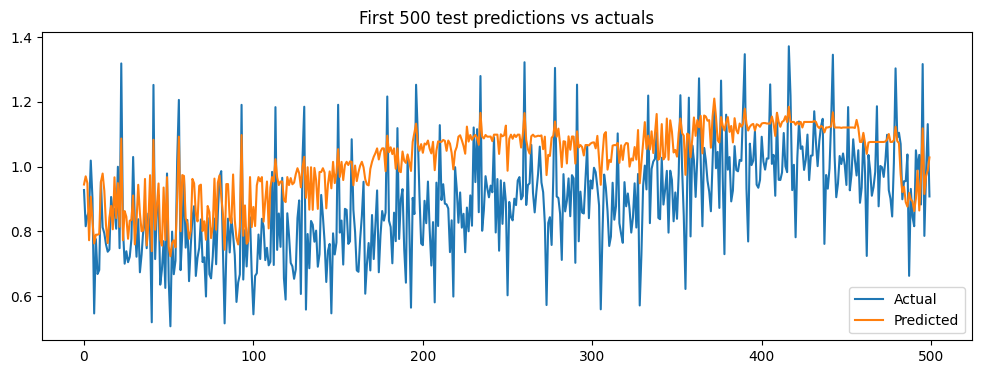


Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412295 | Test samples: 203208


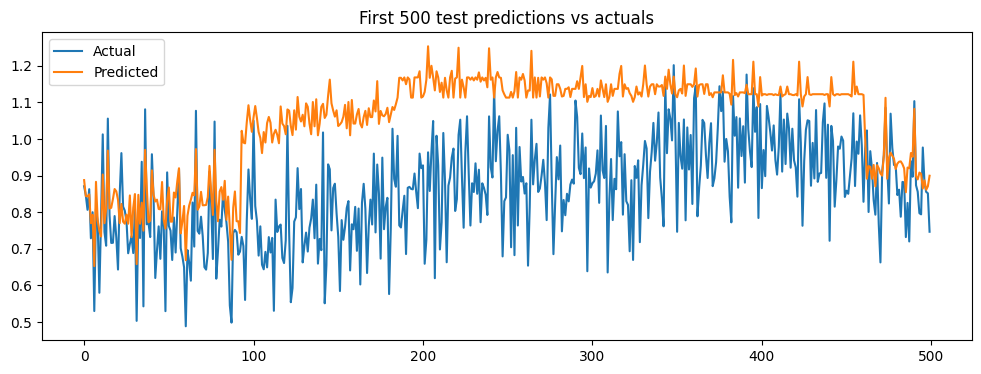


Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221268


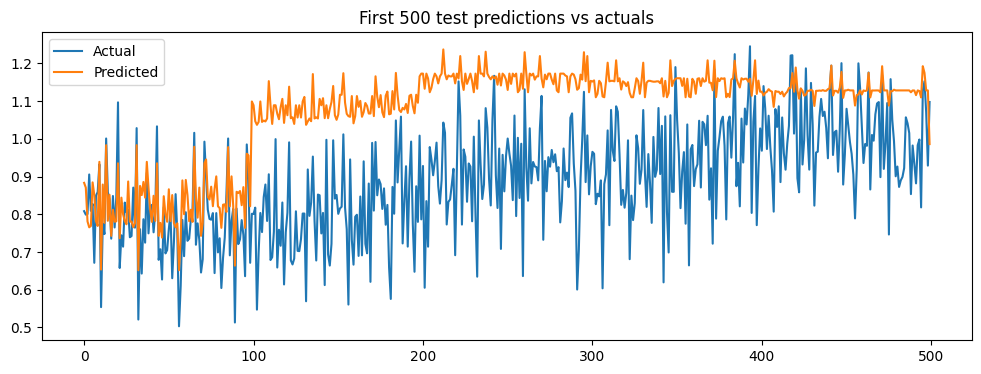


Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424476 | Test samples: 234723


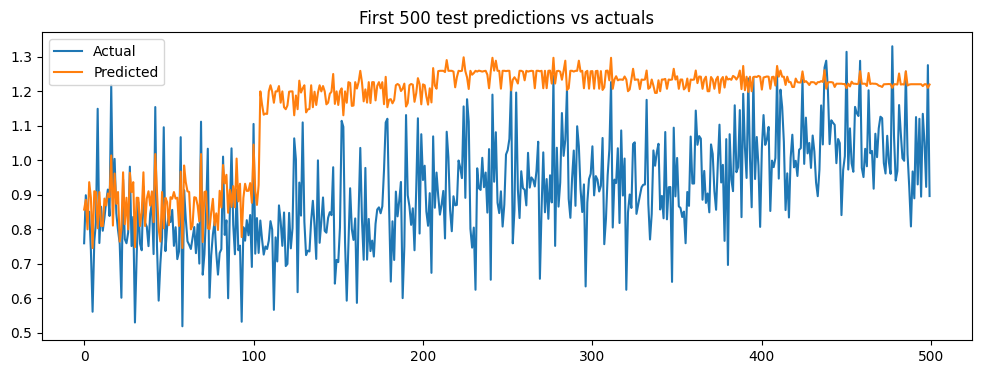


Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455991 | Test samples: 252351


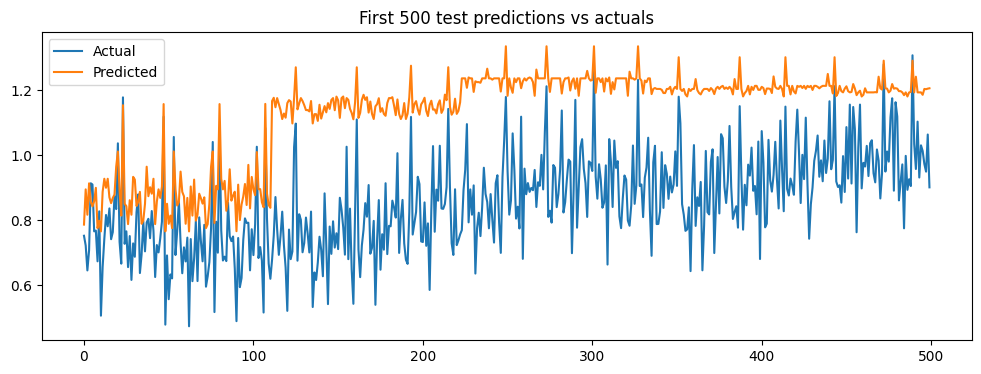


Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487074 | Test samples: 282857


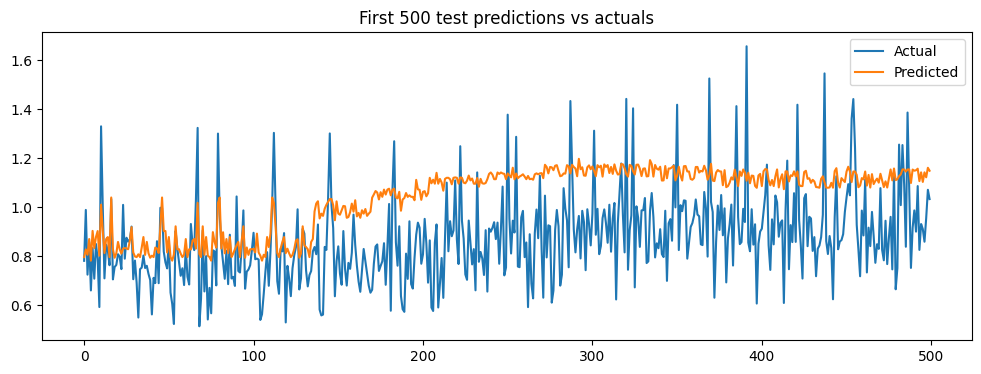


Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535208 | Test samples: 289867


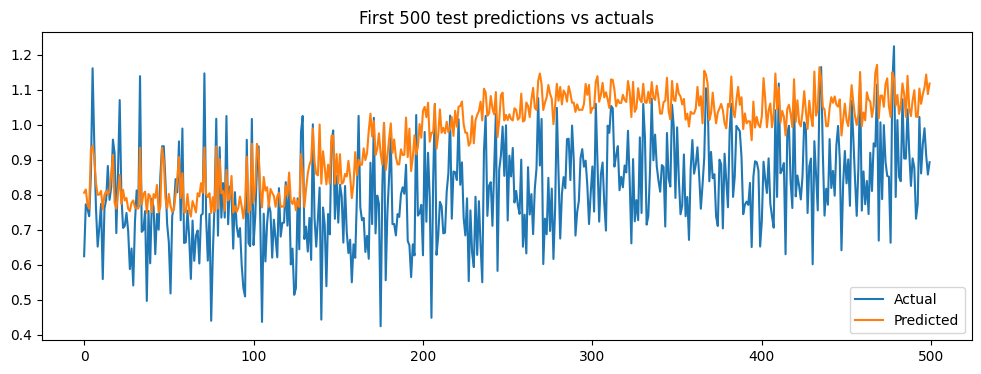


Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572724 | Test samples: 304062


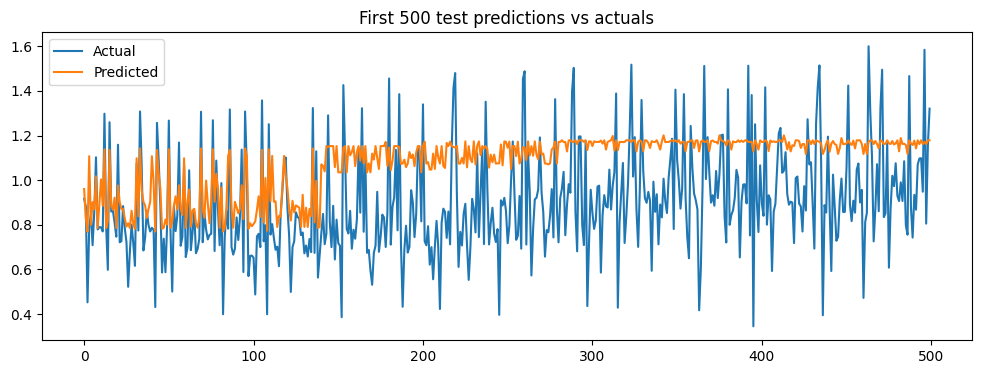

Overall Train Metrics:
MAE: 0.08760315453941225
RMSE: 0.1123520170930955
R²: 0.6560329062586324
Overall Test Metrics:
MAE: 0.10033581153598807
RMSE: 0.12963000188373905
R²: 0.5581474562912134


In [ ]:
dml_pliv_deamnd_lag_tretm_dem, filtered_data_deamnd_lag_tretm_dem, importance_df_deamnd_lag_tretm_dem, fold_metrics_df_deamnd_lag_tretm_dem, importance_all_folds_df_deamnd_lag_tretm_dem, fold_coefficients_deamnd_lag_tretm_dem, predicted_ml_l_dem = dml_rolling_nuins_price_dm(processed_end_dem_price,
                                                                                                                             covariates_end_dem_price,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
print(dml_pliv_deamnd_lag_tretm_dem)

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_90', 'HourOfWeek_108', 'HourOfWeek_14', 'HourOfWeek_150', 'HourOfWeek_112', 'block_5.0:tempbin', 'HourOfWeek_29', 'Month_10', 'HourOfWeek_6', 'PriceArea_NL', 'HourOfWeek_63', 'PriceArea_SE_1', 'HourOfWeek_35', 'HourOfWeek_119', 'HourOfWeek_148', 'HourOfWeek_7', 'HourOfWeek_34', 'Price_gas', 'HourOfWeek_93', 'HourOfWeek_76', 'HourOfWeek_146', 'HourOfWeek_9', 'HourOfWeek_120', 'HourOfWeek_154', 'HourOfWeek_82', 'HourOfWeek_12', 'HourOfWeek_104', 'PriceArea_HR', 'PriceArea_IT_CSUD', 'HourOfWeek_42', 'HourOfWeek_158', 'HourOfWeek_165', 'PriceArea_GR', 'block_3.0:tempbin2', 'HourOfWeek_129', 'HourOfWeek_87', 'HourOfWeek_130', 'PriceArea_SE_4', 'Month_3', 'HourOfWeek_25', 'block_1.0:Solar_MWh',

In [ ]:
covariates_regression = [var for var in covariates_end_dem_price if var not in ['HourOfWeek_0', 'Month_1']]

In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation', 'Lag1_Total_Wind_Generation', 'Lag2_Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_deamnd_lag_tretm_dem[outcome_var]
D = filtered_data_deamnd_lag_tretm_dem[treatment_var]
Z = filtered_data_deamnd_lag_tretm_dem[instrument_vars]
W = filtered_data_deamnd_lag_tretm_dem[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_deamnd_lag_tretm_dem[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                      0.7302
Estimator:                        IV-2SLS   Adj. R-squared:                 0.7302
No. Observations:                 1844270   F-statistic:                -8.248e+12
Date:                    Mon, Apr 14 2025   P-value (F-stat)                1.0000
Time:                            20:46:29   Distribution:                chi2(240)
Cov. Estimator:                 clustered                                         
                                                                                  
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
HourOfWeek_90             0.2843     0.0537     5.2921     0.0000 

In [ ]:
filtered_data_deamnd_lag_tretm_dem.to_csv("filtered_data_2lags_tretm_dem_price.csv", index=False)
importance_df_deamnd_lag_tretm_dem.to_csv("importance_df_2lags_tretm_dem_price.csv", index=False)
fold_coefficients_deamnd_lag_tretm_dem = pd.DataFrame(fold_coefficients_deamnd_lag_tretm_dem)
fold_coefficients_deamnd_lag_tretm_dem.to_csv("fold_coefficients_2lags_tretm_dem_price.csv", index=False)

In [ ]:
importance_df_deamnd_lag_tretm_dem

Feature  Mean Importance  Std Importance
228  block_6.0:tempbin2         0.071537        0.003957
125   block_1.0:tempbin         0.066121        0.015904
232  block_1.0:tempbin2         0.065019        0.005389
119   block_6.0:tempbin         0.055789        0.016952
99              Month_1         0.030854        0.008175
..                  ...              ...             ...
74        HourOfWeek_61         0.000000        0.000000
149       HourOfWeek_72         0.000000        0.000000
208      HourOfWeek_115         0.000000        0.000000
75        HourOfWeek_16         0.000000        0.000000
92        HourOfWeek_37         0.000000        0.000000

[239 rows x 3 columns]

In [ ]:
top_50_features = importance_df_deamnd_lag_tretm_dem.sort_values(
    by='Mean Importance', ascending=False
).head(50)['Feature'].tolist()
top_50_features

['block_6.0:tempbin2',
 'block_1.0:tempbin',
 'block_1.0:tempbin2',
 'block_6.0:tempbin',
 'Month_1',
 'Month_2',
 'HourOfWeek_149',
 'HourOfWeek_150',
 'Month_5',
 'HourOfWeek_125',
 'HourOfWeek_151',
 'Month_12',
 'HourOfWeek_157',
 'HourOfWeek_158',
 'HourOfWeek_156',
 'HourOfWeek_126',
 'HourOfWeek_153',
 'HourOfWeek_155',
 'HourOfWeek_159',
 'HourOfWeek_154',
 'HourOfWeek_164',
 'HourOfWeek_140',
 'HourOfWeek_56',
 'HourOfWeek_152',
 'HourOfWeek_132',
 'HourOfWeek_134',
 'HourOfWeek_80',
 'HourOfWeek_32',
 'HourOfWeek_69',
 'HourOfWeek_45',
 'HourOfWeek_133',
 'HourOfWeek_93',
 'HourOfWeek_160',
 'HourOfWeek_21',
 'Month_3',
 'HourOfWeek_131',
 'HourOfWeek_104',
 'HourOfWeek_135',
 'HourOfWeek_55',
 'HourOfWeek_163',
 'block_5.0:tempbin',
 'Month_4',
 'HourOfWeek_31',
 'HourOfWeek_79',
 'HourOfWeek_65',
 'HourOfWeek_130',
 'HourOfWeek_41',
 'HourOfWeek_129',
 'HourOfWeek_89',
 'HourOfWeek_127']

# Importance


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401770 | Test samples: 209955


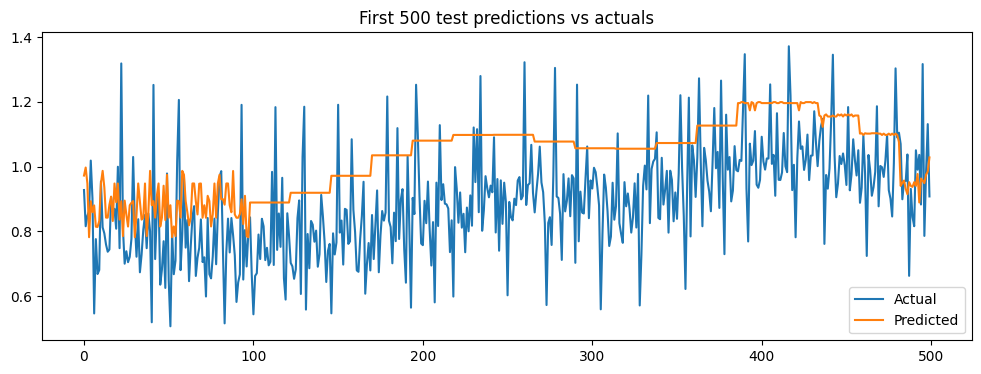


Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412295 | Test samples: 203208


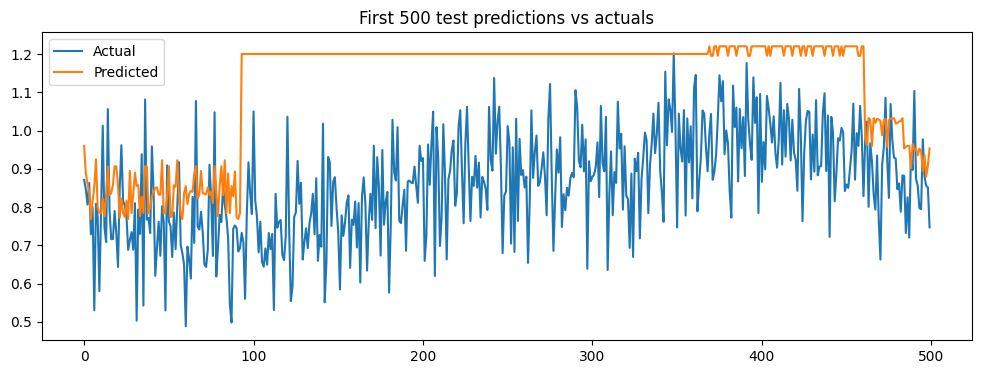


Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221268


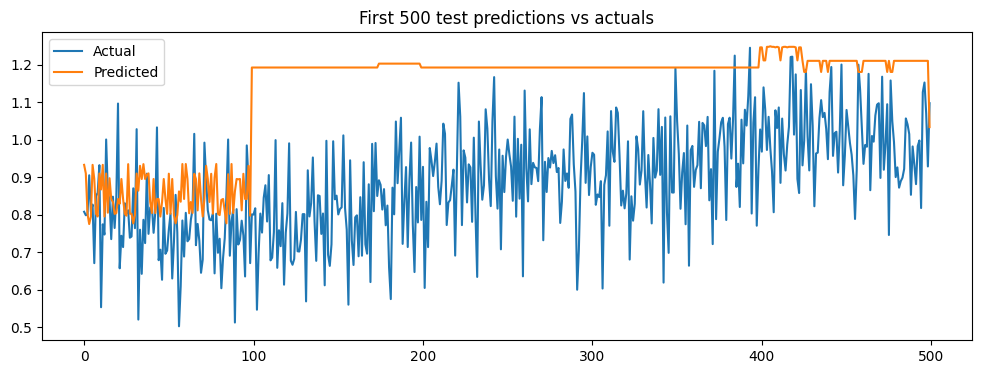


Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424476 | Test samples: 234723


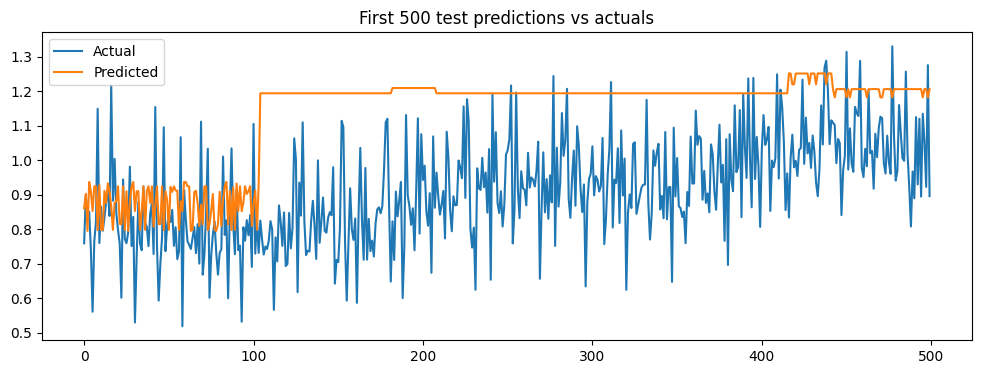


Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455991 | Test samples: 252351


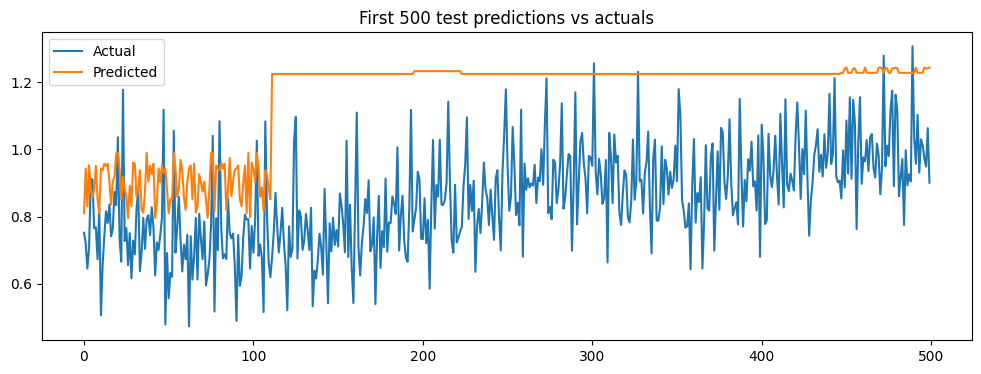


Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487074 | Test samples: 282857


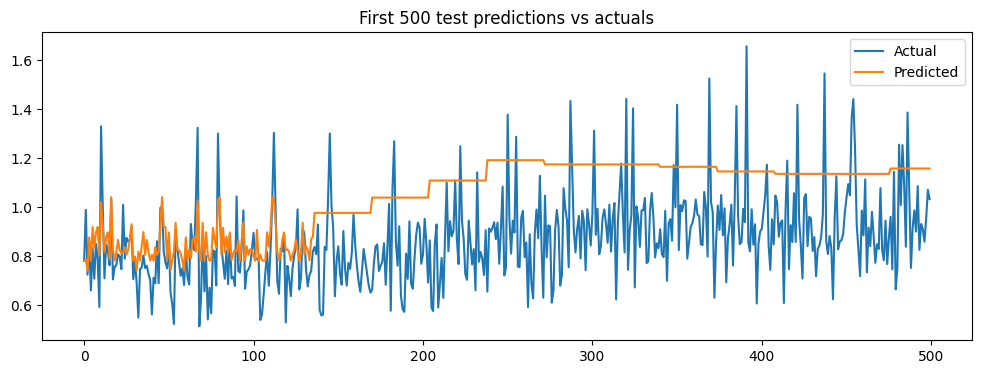


Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535208 | Test samples: 289867


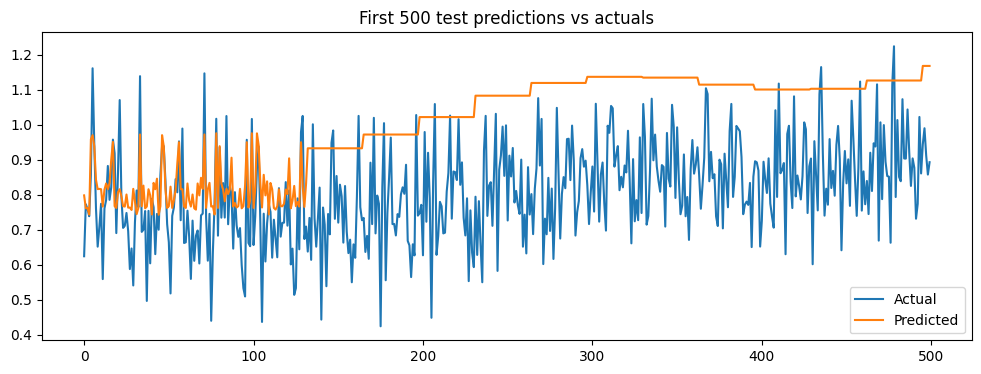


Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572724 | Test samples: 304062


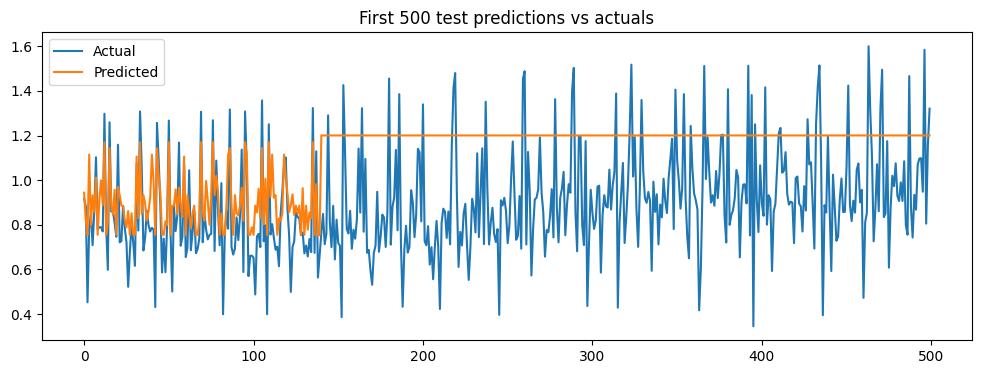

Overall Train Metrics:
MAE: 0.09867571623726114
RMSE: 0.12827958800077752
R²: 0.5515951905143848
Overall Test Metrics:
MAE: 0.10316222262034709
RMSE: 0.1345161849791813
R²: 0.5242099140545629


In [ ]:
dml_pliv_deamnd_lag_tretm_dem, filtered_data_deamnd_lag_tretm_dem, importance_df_deamnd_lag_tretm_dem, fold_metrics_df_deamnd_lag_tretm_dem, importance_all_folds_df_deamnd_lag_tretm_dem, fold_coefficients_deamnd_lag_tretm_dem, predicted_ml_l_dem = dml_rolling_nuins_price_dm(processed_end_dem_price,
                                                                                                                             top_50_features,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
print(dml_pliv_deamnd_lag_tretm_dem)

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR', 'Lag1_Consumption', 'Lag1_DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['block_6.0:tempbin2', 'block_1.0:tempbin', 'block_1.0:tempbin2', 'block_6.0:tempbin', 'Month_1', 'Month_2', 'HourOfWeek_149', 'HourOfWeek_150', 'Month_5', 'HourOfWeek_125', 'HourOfWeek_151', 'Month_12', 'HourOfWeek_157', 'HourOfWeek_158', 'HourOfWeek_156', 'HourOfWeek_126', 'HourOfWeek_153', 'HourOfWeek_155', 'HourOfWeek_159', 'HourOfWeek_154', 'HourOfWeek_164', 'HourOfWeek_140', 'HourOfWeek_56', 'HourOfWeek_152', 'HourOfWeek_132', 'HourOfWeek_134', 'HourOfWeek_80', 'HourOfWeek_32', 'HourOfWeek_69', 'HourOfWeek_45', 'HourOfWeek_133', 'HourOfWeek_93', 'HourOfWeek_160', 'HourOfWeek_21', 'Month_3', 'HourOfWeek_131', 'HourOfWeek_104', 'HourOfWeek_135', 'HourOfWeek_55', 'HourOfWeek_163', 'block_5.0:tempbi

In [ ]:
filtered_data_deamnd_lag_tretm_dem.to_csv("filtered_data_2lags_tretm_dem_price_importance.csv", index=False)
importance_df_deamnd_lag_tretm_dem.to_csv("importance_df_2lags_tretm_dem_price_importance.csv", index=False)
fold_coefficients_deamnd_lag_tretm_dem = pd.DataFrame(fold_coefficients_deamnd_lag_tretm_dem)
fold_coefficients_deamnd_lag_tretm_dem.to_csv("fold_coefficients_2lags_tretm_dem_price_importance.csv", index=False)

# LOG

In [ ]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    apply_log_transform = True
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    if apply_log_transform:
        log_vars = [
            'consumption_normalized', 'DayAheadPriceEUR',
            'Total_Wind_Generation',
            'Price_gas', 'Price_coal', 'Price_EUA', 'Solar_MWh'
        ]

        # Apply log transformation
        epsilon = 1e-3
        data['log_consumption'] = np.log(data['consumption_normalized'].clip(lower=epsilon))
        data['log_DayAheadPriceEUR'] = np.log(data['DayAheadPriceEUR'].clip(lower=epsilon))
        data['log_Total_Wind_Generation'] = np.log(data['Total_Wind_Generation'].clip(lower=epsilon))
        data['log_Price_gas'] = np.log(data['Price_gas'].clip(lower=epsilon))
        data['log_Price_coal'] = np.log(data['Price_coal'].clip(lower=epsilon))
        data['log_Price_EUA'] = np.log(data['Price_EUA'].clip(lower=epsilon))
        data['log_Solar_MWh'] = np.log(data['Solar_MWh'].clip(lower=epsilon))

        # Update base_covariates and include_interactions
        if base_covariates:
            base_covariates = [f"log_{var}" if var in log_vars else var for var in base_covariates]
        if include_interactions:
            for k, v in include_interactions.items():
                include_interactions[k] = [f"log_{x}" if x in log_vars else x for x in v]

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Optionally add lagged features
    data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
    data['log_Lag1_Consumption'] = np.log(data['Lag1_Consumption'].clip(lower=epsilon))

    data['Lag1_Total_Wind_Generation'] = data.groupby('Country')['Total_Wind_Generation'].shift(1)
    data['log_Lag1_Total_Wind_Generation'] = np.log(data['Lag1_Total_Wind_Generation'].clip(lower=epsilon))

    data['Lag2_Total_Wind_Generation'] = data.groupby('Country')['Total_Wind_Generation'].shift(2)
    data['log_Lag2_Total_Wind_Generation'] = np.log(data['Lag2_Total_Wind_Generation'].clip(lower=epsilon))


    data['Lag1_DayAheadPriceEUR'] = data.groupby('Country')['DayAheadPriceEUR'].shift(1)
    data['log_Lag1_DayAheadPriceEUR'] = np.log(data['Lag1_DayAheadPriceEUR'].clip(lower=epsilon))



    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    endogenous_variable = ['log_DayAheadPriceEUR', 'log_Lag1_Consumption', 'log_Lag1_DayAheadPriceEUR']
    instrument_variables = ['log_Total_Wind_Generation', 'log_Lag1_Total_Wind_Generation', 'log_Lag2_Total_Wind_Generation']

    key_variables = [dependent_variable] + endogenous_variable + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [ ]:
processed_end_dem_price, covariates_end_dem_price = prepare_data_with_dummies_and_interactions(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)
processed_end_dem_price = processed_end_dem_price[processed_end_dem_price['Time'].dt.year != 2025]
processed_end_dem_price

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
34.0                41.0 2015-01-01 03:00:00          20264.00   
33.0                42.0 2015-01-01 03:00:00           4879.00   
31.0                45.0 2015-01-01 03:00:00           5828.00   
30.0                46.0 2015-01-01 03:00:00            747.00   
29.0                47.0 2015-01-01 03:00:00           1190.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00            547.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
34.0                     38.41          6.339060          278.225769  2015   
33.0                     25.40         14.278077          274.781555  2015   
31.0                     19.17          5.852193          271.318787  2015   
30.0                     17.53          7.799719          273.991302  2015   
29.0                     14.95         11.110504          277.601593  2015   
...                        ...               ...                 ...   ...   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                     138.70          1.776654          284.461456  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  block_6.0:tempbin2  \
Unnamed: 0.1                                    ...                       
34.0           1.0   3.0             41.136384  ...            0.000000   
33.0           1.0   3.0             34.936799  ...            0.000000   
31.0           1.0   3.0             28.703816  ...            0.000000   
30.0           1.0   3.0             33.514344  ...            0.000000   
29.0           1.0   3.0             40.012867  ...            0.000000   
...            ...   ...                   ...  ...                 ...   
NaN           31.0  23.0             50.992439  ...            2.600229   
NaN           31.0  23.0             39.085511  ...            1.527677   
NaN           31.0  23.0             25.749757  ...            0.663050   
NaN           31.0  23.0             52.360621  ...            2.741635   
NaN           31.0  23.0             39.424275  ...            1.554273   

              block_6.0:log_Solar_MWh  Lag1_Consumption log_Lag1_Consumption  \
Unnamed: 0.1                                                                   
34.0                         0.000000          0.750672            -0.286787   
33.0                        -0.000000          0.857904            -0.153263   
31.0                        -0.000000          0.811352            -0.209054   
30.0                        -0.000000          0.828510            -0.188126   
29.0                        -0.000000          0.829951            -0.186389   
...                               ...               ...                  ...   
NaN                         -6.907755          0.835920            -0.179222   
NaN                         -6.907755          1.011109             0.011048   
NaN                         -6.907755          1.061121             0.059326   
NaN                         -6.907755          0.829072            -0.187449   
NaN                         -6.907755          1.010044             0.009994   

              Lag1_Total_Wind_Generation  log_Lag1_Total_Wind_Generation  \
Unnamed: 0.1                                   

In [ ]:
covariates_end_dem_price

['HourOfWeek_56',
 'HourOfWeek_74',
 'HourOfWeek_84',
 'block_2.0:tempbin',
 'PriceArea_DK_2',
 'log_Price_coal',
 'HourOfWeek_95',
 'HourOfWeek_142',
 'HourOfWeek_30',
 'HourOfWeek_45',
 'HourOfWeek_151',
 'HourOfWeek_132',
 'HourOfWeek_93',
 'HourOfWeek_78',
 'HourOfWeek_23',
 'HourOfWeek_43',
 'HourOfWeek_81',
 'PriceArea_FI',
 'HourOfWeek_111',
 'HourOfWeek_6',
 'HourOfWeek_68',
 'HourOfWeek_158',
 'HourOfWeek_69',
 'HourOfWeek_42',
 'HourOfWeek_138',
 'HourOfWeek_166',
 'HourOfWeek_38',
 'Month_10',
 'HourOfWeek_67',
 'HourOfWeek_62',
 'PriceArea_PT',
 'HourOfWeek_128',
 'HourOfWeek_54',
 'PriceArea_IT_NORD',
 'HourOfWeek_146',
 'HourOfWeek_119',
 'HourOfWeek_79',
 'HourOfWeek_39',
 'PriceArea_EE',
 'HourOfWeek_148',
 'PriceArea_IT_CNOR',
 'HourOfWeek_53',
 'HourOfWeek_163',
 'Month_5',
 'block_4.0:tempbin',
 'HourOfWeek_96',
 'HourOfWeek_58',
 'PriceArea_NL',
 'HourOfWeek_87',
 'HourOfWeek_145',
 'block_5.0:tempbin2',
 'HourOfWeek_41',
 'HourOfWeek_116',
 'HourOfWeek_77',
 'HourO

In [ ]:
def dml_rolling_nuins_price_dm(filtered_data, base_covariates, manual_params_l=None, manual_params_r=None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable='consumption_normalized'):


    data = filtered_data.copy()
    data = data.sort_values(by='Time')
    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    covariates = base_covariates.copy()
    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]


    def tune_xgb_model(X, y, param_dist):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist",
                                 eval_metric="rmse"
                                )
        grid_search = GridSearchCV(model, param_dist, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_

    pred_dict = {
        'log_DayAheadPriceEUR': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_log_Total_Wind_Generation': [],
            'ml_m_log_Lag1_Total_Wind_Generation': [],
            'ml_m_log_Lag2_Total_Wind_Generation': []
        },
        'log_Lag1_Consumption': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_log_Total_Wind_Generation': [],
            'ml_m_log_Lag1_Total_Wind_Generation': [],
            'ml_m_log_Lag2_Total_Wind_Generation': []
        },
        'log_Lag1_DayAheadPriceEUR': {
            'ml_l': [],
            'ml_r': [],
            'ml_m_log_Total_Wind_Generation': [],
            'ml_m_log_Lag1_Total_Wind_Generation': [],
            'ml_m_log_Lag2_Total_Wind_Generation': []
        }
    }

    test_predictions = []
    test_actuals = []
    train_predictions = []
    train_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    fold_feature_importance_df = []
    fold_coefficients = []
    time_indices = []

    train_predictions_r = []
    test_predictions_r = []
    train_actuals_r = []
    test_actuals_r = []

    train_predictions_m = []
    test_predictions_m = []
    train_actuals_m = []
    test_actuals_m = []

    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue

        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")



        X_train = train_data[covariates]
        X_test = test_data[covariates]
        y_train = train_data[dependent_variable]
        y_test = test_data[dependent_variable]

        d_train_r1 = train_data['log_DayAheadPriceEUR']
        d_test_r1 = test_data['log_DayAheadPriceEUR']
        d_train_r2 = train_data['log_Lag1_Consumption']
        d_train_r3 = train_data['log_Lag1_DayAheadPriceEUR']
        z_train_m1 = train_data['log_Total_Wind_Generation']
        z_test_m1 = test_data['log_Total_Wind_Generation']
        z_train_m2 = train_data['log_Lag1_Total_Wind_Generation']
        z_train_m3 = train_data['log_Lag2_Total_Wind_Generation']

        learner_l = xgb.XGBRegressor(**(manual_params_l or tune_xgb_model(X_train, y_train, param_dist_xgb)))
        learner_r1 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r1, param_dist_xgb_r)))
        learner_r2 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r2, param_dist_xgb_r)))
        learner_r3 = xgb.XGBRegressor(**(manual_params_r or tune_xgb_model(X_train, d_train_r3, param_dist_xgb_r)))
        learner_m1 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m1, param_dist_xgb_m)))
        learner_m2 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m2, param_dist_xgb_m)))
        learner_m3 = xgb.XGBRegressor(**(manual_params_m or tune_xgb_model(X_train, z_train_m3, param_dist_xgb_m)))

        learner_l.fit(X_train, y_train)
        learner_r1.fit(X_train, d_train_r1)
        learner_r2.fit(X_train, d_train_r2)
        learner_r3.fit(X_train, d_train_r3)
        learner_m1.fit(X_train, z_train_m1)
        learner_m2.fit(X_train, z_train_m2)
        learner_m3.fit(X_train, z_train_m3)

        pred_l = learner_l.predict(X_test)
        pred_r1 = learner_r1.predict(X_test)
        pred_r2 = learner_r2.predict(X_test)
        pred_r3 = learner_r3.predict(X_test)
        pred_m1 = learner_m1.predict(X_test)
        pred_m2 = learner_m2.predict(X_test)
        pred_m3 = learner_m3.predict(X_test)

        test_predictions.extend(pred_l)
        test_actuals.extend(y_test)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train)
        time_indices.extend(test_data.index.tolist())

        train_predictions_r.extend(learner_r1.predict(X_train))
        train_actuals_r.extend(d_train_r1)
        test_predictions_r.extend(learner_r1.predict(X_test))
        test_actuals_r.extend(d_test_r1)

        train_predictions_m.extend(learner_m1.predict(X_train))
        train_actuals_m.extend(z_train_m1)
        test_predictions_m.extend(learner_m1.predict(X_test))
        test_actuals_m.extend(z_test_m1)

        pred_dict['log_DayAheadPriceEUR']['ml_l'].extend(pred_l)
        pred_dict['log_DayAheadPriceEUR']['ml_r'].extend(pred_r1)
        pred_dict['log_DayAheadPriceEUR']['ml_m_log_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['log_DayAheadPriceEUR']['ml_m_log_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['log_DayAheadPriceEUR']['ml_m_log_Lag2_Total_Wind_Generation'].extend(pred_m3)
        pred_dict['log_Lag1_Consumption']['ml_l'].extend(pred_l)
        pred_dict['log_Lag1_Consumption']['ml_r'].extend(pred_r2)
        pred_dict['log_Lag1_Consumption']['ml_m_log_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['log_Lag1_Consumption']['ml_m_log_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['log_Lag1_Consumption']['ml_m_log_Lag2_Total_Wind_Generation'].extend(pred_m3)
        pred_dict['log_Lag1_DayAheadPriceEUR']['ml_l'].extend(pred_l)
        pred_dict['log_Lag1_DayAheadPriceEUR']['ml_r'].extend(pred_r1)
        pred_dict['log_Lag1_DayAheadPriceEUR']['ml_m_log_Total_Wind_Generation'].extend(pred_m1)
        pred_dict['log_Lag1_DayAheadPriceEUR']['ml_m_log_Lag1_Total_Wind_Generation'].extend(pred_m2)
        pred_dict['log_Lag1_DayAheadPriceEUR']['ml_m_log_Lag2_Total_Wind_Generation'].extend(pred_m3)

        plt.figure(figsize=(12, 4))
        plt.plot(y_test.iloc[:500].values, label='Actual')
        plt.plot(pred_l[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()

        fold_metrics.append({
            'Test Year': test_year,
            'MAE': mean_absolute_error(y_test, pred_l),
            'RMSE': mean_squared_error(y_test, pred_l, squared=False),
            'R2': r2_score(y_test, pred_l)
        })

        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))

        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols=['log_DayAheadPriceEUR', 'log_Lag1_Consumption', 'log_Lag1_DayAheadPriceEUR'],
            z_cols=['log_Total_Wind_Generation', 'log_Lag1_Total_Wind_Generation', 'log_Lag2_Total_Wind_Generation'],
            x_cols=covariates,
            cluster_cols=['Country']
        )
        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'log_DayAheadPriceEUR': {
                'ml_l': np.array(pred_dict['log_DayAheadPriceEUR']['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict['log_DayAheadPriceEUR']['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Total_Wind_Generation': np.array(pred_dict['log_DayAheadPriceEUR']['ml_m_log_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Lag1_Total_Wind_Generation': np.array(pred_dict['log_DayAheadPriceEUR']['ml_m_log_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Lag2_Total_Wind_Generation': np.array(pred_dict['log_DayAheadPriceEUR']['ml_m_log_Lag2_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
            },
            'log_Lag1_Consumption': {
                'ml_l': np.array(pred_dict['log_Lag1_Consumption']['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict['log_Lag1_Consumption']['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Total_Wind_Generation': np.array(pred_dict['log_Lag1_Consumption']['ml_m_log_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Lag1_Total_Wind_Generation': np.array(pred_dict['log_Lag1_Consumption']['ml_m_log_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Lag2_Total_Wind_Generation': np.array(pred_dict['log_Lag1_Consumption']['ml_m_log_Lag2_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
            },
            'log_Lag1_DayAheadPriceEUR': {
                'ml_l': np.array(pred_dict['log_Lag1_DayAheadPriceEUR']['ml_l'][-len(X_test):]).reshape(-1, 1),
                'ml_r': np.array(pred_dict['log_Lag1_DayAheadPriceEUR']['ml_r'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Total_Wind_Generation': np.array(pred_dict['log_Lag1_DayAheadPriceEUR']['ml_m_log_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Lag1_Total_Wind_Generation': np.array(pred_dict['log_Lag1_DayAheadPriceEUR']['ml_m_log_Lag1_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
                'ml_m_log_Lag2_Total_Wind_Generation': np.array(pred_dict['log_Lag1_DayAheadPriceEUR']['ml_m_log_Lag2_Total_Wind_Generation'][-len(X_test):]).reshape(-1, 1),
            }
        })


        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })
        feature_importances_per_window.append(learner_l.feature_importances_)


    print("Overall Train Metrics:")
    print("MAE:", mean_absolute_error(train_actuals, train_predictions))
    print("RMSE:", mean_squared_error(train_actuals, train_predictions, squared=False))
    print("R²:", r2_score(train_actuals, train_predictions))

    print("Overall Test Metrics:")
    print("MAE:", mean_absolute_error(test_actuals, test_predictions))
    print("RMSE:", mean_squared_error(test_actuals, test_predictions, squared=False))
    print("R²:", r2_score(test_actuals, test_predictions))


    train_mae_r = mean_absolute_error(train_actuals_r, train_predictions_r)
    train_rmse_r = mean_squared_error(train_actuals_r, train_predictions_r, squared=False)
    train_r2_r = r2_score(train_actuals_r, train_predictions_r)

    test_mae_r = mean_absolute_error(test_actuals_r, test_predictions_r)
    test_rmse_r = mean_squared_error(test_actuals_r, test_predictions_r, squared=False)
    test_r2_r = r2_score(test_actuals_r, test_predictions_r)

    print("Overall Train Metrics R:")
    print(f"MAE: {train_mae_r}, RMSE: {train_rmse_r}, R²: {train_r2_r}")

    print("Overall Test Metrics R:")
    print(f"MAE: {test_mae_r}, RMSE: {test_rmse_r}, R²: {test_r2_r}")

    train_mae_m = mean_absolute_error(train_actuals_m, train_predictions_m)
    train_rmse_m = mean_squared_error(train_actuals_m, train_predictions_m, squared=False)
    train_r2_m = r2_score(train_actuals_m, train_predictions_m)

    test_mae_m = mean_absolute_error(test_actuals_m, test_predictions_m)
    test_rmse_m = mean_squared_error(test_actuals_m, test_predictions_m, squared=False)
    test_r2_m = r2_score(test_actuals_m, test_predictions_m)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae_m}, RMSE: {train_rmse_m}, R²: {train_r2_m}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae_m}, RMSE: {test_rmse_m}, R²: {test_r2_m}")

    # Safely compute average feature importances across folds, or return empty DataFrame
    try:
        feature_importances_array = np.array(feature_importances_per_window)
        if feature_importances_array.size > 0:
            mean_importances = feature_importances_array.mean(axis=0)
            std_importances = feature_importances_array.std(axis=0)
            importance_df = pd.DataFrame({
                'Feature': covariates,
                'Mean Importance': mean_importances,
                'Std Importance': std_importances
            }).sort_values(by='Mean Importance', ascending=False)
        else:
            raise ValueError("No feature importances recorded.")
    except Exception as e:
        print(f"Warning: Could not compute mean feature importances. Reason: {e}")
        importance_df = pd.DataFrame(columns=['Feature', 'Mean Importance', 'Std Importance'])




    # Remove NaNs and ensure integer type
    time_indices = [i for i in time_indices if pd.notna(i)]
    filtered_data = data.loc[time_indices].copy().reset_index(drop=True)
    treatments = ['log_DayAheadPriceEUR', 'log_Lag1_Consumption', 'log_Lag1_DayAheadPriceEUR']
    learners = ['ml_l', 'ml_r',
                'ml_m_log_Total_Wind_Generation',
                'ml_m_log_Lag1_Total_Wind_Generation',
                'ml_m_log_Lag2_Total_Wind_Generation']

    n_obs = len(filtered_data)
    for treatment, learners in pred_dict.items():
        for learner_key, values in learners.items():
            pred_dict[treatment][learner_key] = np.array(values[-n_obs:]).reshape(-1, 1)


    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols=['log_DayAheadPriceEUR', 'log_Lag1_Consumption', 'log_Lag1_DayAheadPriceEUR'],
        z_cols=['log_Total_Wind_Generation', 'log_Lag1_Total_Wind_Generation', 'log_Lag2_Total_Wind_Generation'],
        x_cols=covariates,
        cluster_cols=['Country']
    )
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
    dml_pliv_obj.fit(external_predictions=pred_dict)
    print(dml_pliv_obj)

    predicted_ml_l = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Prrediction"] = predicted_ml_l[-len(filtered_data):]
    filtered_data["Residuals"] = filtered_data["Prrediction"] - filtered_data[dependent_variable]


    return dml_pliv_obj, filtered_data, importance_df, pd.DataFrame(fold_metrics), pd.concat(fold_feature_importance_df, ignore_index=True), fold_coefficients, predicted_ml_l


In [ ]:
manual_params_l = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.02,
    'max_depth': 5,
    'n_estimators': 400,
    'subsample': 0.8
}

manual_params_r = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'subsample': 0.7
}

manual_params_m = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.01,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 0.9
}


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401770 | Test samples: 209955


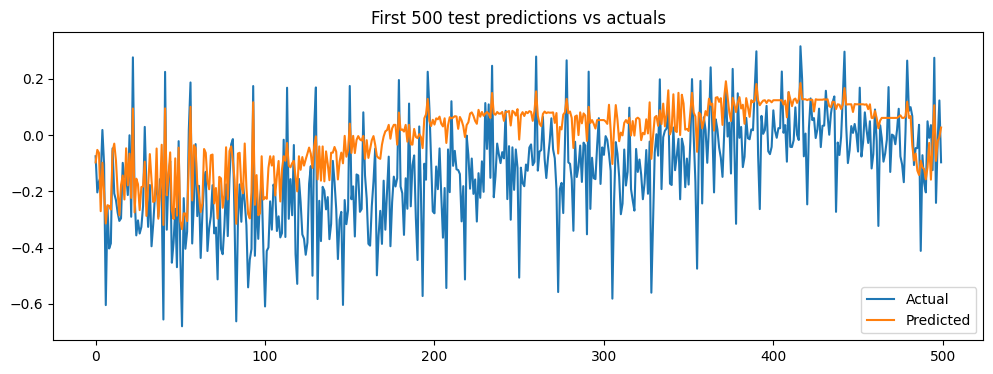


Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412295 | Test samples: 203208


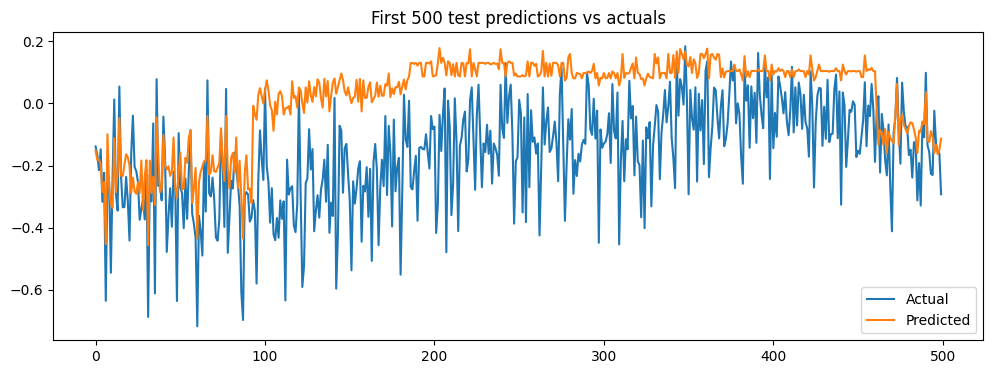


Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221268


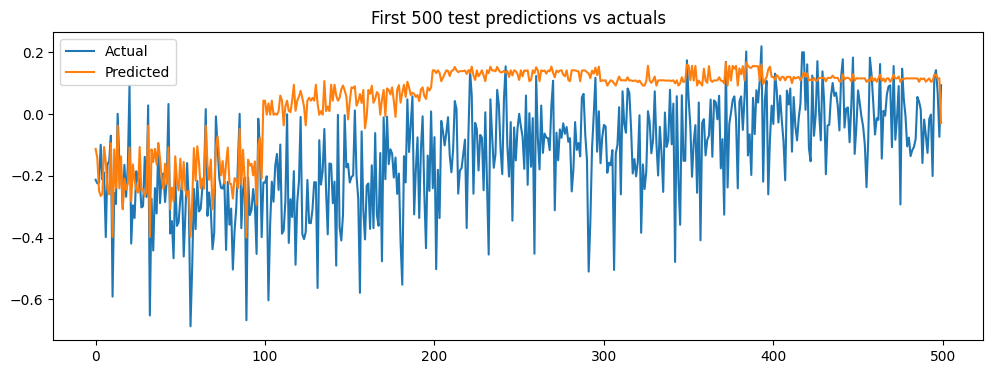


Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424476 | Test samples: 234723


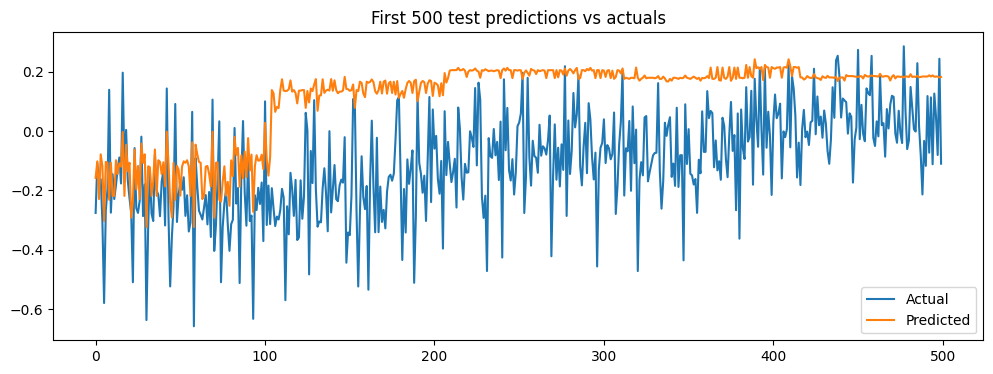


Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455991 | Test samples: 252351


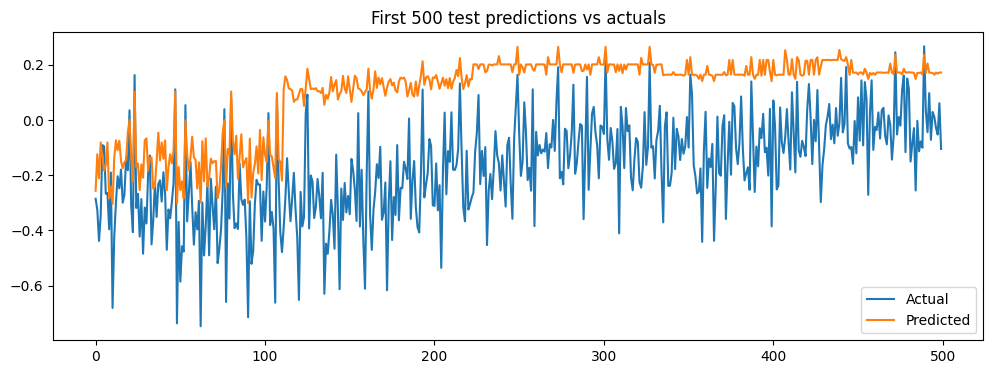


Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487074 | Test samples: 282857


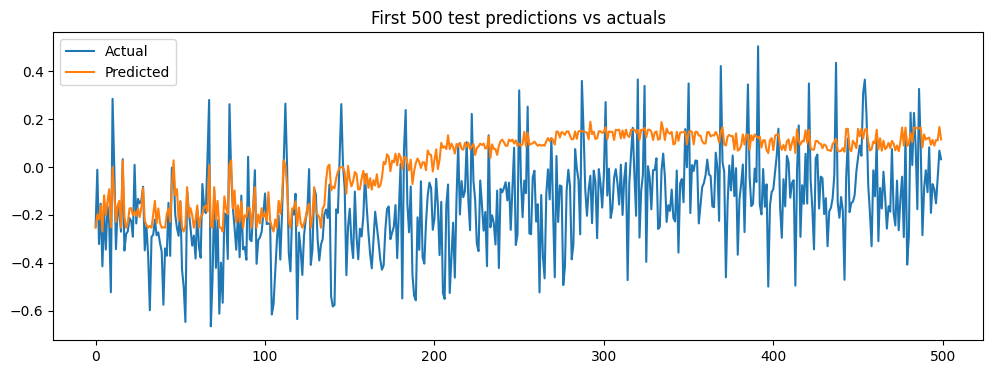


Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535208 | Test samples: 289867


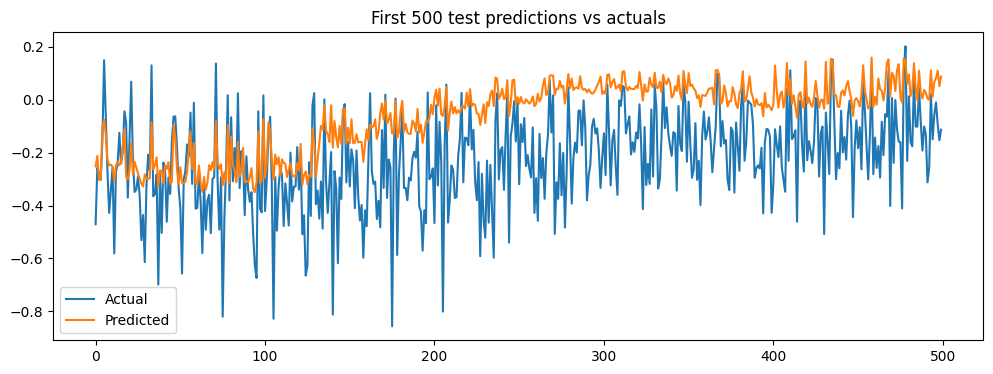


Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572724 | Test samples: 304062


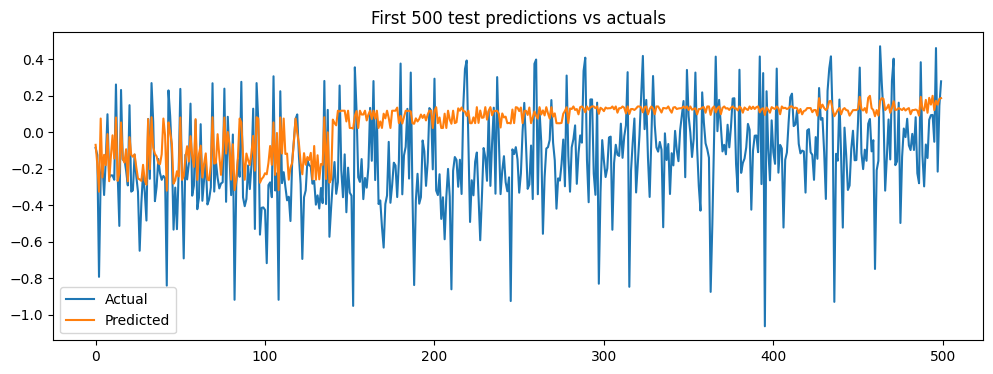

Overall Train Metrics:
MAE: 0.0878850067751391
RMSE: 0.11485117003924006
R²: 0.6583086508584477
Overall Test Metrics:
MAE: 0.10000865577295719
RMSE: 0.13179173121769716
R²: 0.5633053059161767
Overall Train Metrics R:
MAE: 0.4677514104702458, RMSE: 0.939810623945423, R²: 0.369297803037133
Overall Test Metrics R:
MAE: 0.7954553485181692, RMSE: 1.518840706790647, R²: 0.026919293711335057
Overall Train Metrics:
MAE: 1.250206239703713, RMSE: 1.681972474250186, R²: 0.78876466748765
Overall Test Metrics:
MAE: 1.3393563533435253, RMSE: 1.8241112489248588, R²: 0.7327873393886636
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: log_consumption
Treatment variable(s): ['log_DayAheadPriceEUR', 'log_Lag1_Consumption', 'log_Lag1_DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_97', 'HourOfWeek_61', 'HourOfWeek_165', 'HourOfWeek_60', 'HourOfWeek_159', 'HourOfWeek_30', 'HourOfWeek_78', 'HourO

In [ ]:
dml_pliv_deamnd_lag_tretm_dem, filtered_data_deamnd_lag_tretm_dem, importance_df_deamnd_lag_tretm_dem, fold_metrics_df_deamnd_lag_tretm_dem, importance_all_folds_df_deamnd_lag_tretm_dem, fold_coefficients_deamnd_lag_tretm_dem, predicted_ml_l_dem = dml_rolling_nuins_price_dm(processed_end_dem_price,
                                                                                                                             covariates_end_dem_price,
                                                                                                                             dependent_variable = 'log_consumption',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
fold_coefficients_deamnd_lag_tretm_dem

[{'Year': 2017,
  'coef': array([-0.02116048,  0.17940238, -0.0211769 ]),
  'se': array([0.00727349, 0.03892816, 0.00726541]),
  't': array([-2.90926273,  4.60855066, -2.9147552 ]),
  'p': array([3.62282264e-03, 4.05485584e-06, 3.55967645e-03])},
 {'Year': 2018,
  'coef': array([-0.02793488,  0.30681468, -0.02794183]),
  'se': array([0.00531245, 0.04497634, 0.00531326]),
  't': array([-5.25838287,  6.82169092, -5.25888329]),
  'p': array([1.45327703e-07, 8.99750887e-12, 1.44932837e-07])},
 {'Year': 2019,
  'coef': array([ 0.08973306, -1.1904779 ,  0.0891897 ]),
  'se': array([0.01109777, 0.16849942, 0.01099982]),
  't': array([ 8.08568378, -7.06517524,  8.10828453]),
  'p': array([6.18163834e-16, 1.60413431e-12, 5.13394039e-16])},
 {'Year': 2020,
  'coef': array([-0.05918993, -0.45026127, -0.05874138]),
  'se': array([0.01847525, 0.08494922, 0.01829703]),
  't': array([-3.20374167, -5.30035822, -3.21043258]),
  'p': array([1.35654135e-03, 1.15575691e-07, 1.32535355e-03])},
 {'Year': 20

In [ ]:
filtered_data_deamnd_lag_tretm_dem.to_csv("log_nuancies_2.csv", index=False)
importance_df_deamnd_lag_tretm_dem.to_csv("log_nuancies_importance_2.csv", index=False)
fold_coefficients_deamnd_lag_tretm_dem = pd.DataFrame(fold_coefficients_deamnd_lag_tretm_dem)
fold_coefficients_deamnd_lag_tretm_dem.to_csv("log_nuancies_fold_2.csv", index=False)

In [ ]:
filtered_data_deamnd_lag_tretm_dem.to_csv("log_nuancies.csv", index=False)
importance_df_deamnd_lag_tretm_dem.to_csv("log_nuancies_importance.csv", index=False)
fold_coefficients_deamnd_lag_tretm_dem = pd.DataFrame(fold_coefficients_deamnd_lag_tretm_dem)
fold_coefficients_deamnd_lag_tretm_dem.to_csv("log_nuancies_fold.csv", index=False)